In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!ls

gdrive	sample_data


In [4]:
cd gdrive/MyDrive/UNCC/Spring22/Real-Time\ Machine\ Learning

/content/gdrive/MyDrive/UNCC/Spring22/Real-Time Machine Learning


In [5]:
cd Homeworks/Homework\ 3

/content/gdrive/MyDrive/UNCC/Spring22/Real-Time Machine Learning/Homeworks/Homework 3


In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [7]:
from torchvision import datasets, transforms

In [8]:
import time

In [9]:
from tqdm import tqdm

In [10]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [11]:
data_path = 'data/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [12]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [13]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                         shuffle=True)

dataloaders = {'train': train_loader, 
               'val': val_loader}

In [14]:
def training_loop(n_epochs, optimizer, model, loss_fn, dataloader, device):
    training_start_time = time.time()
    dur=[]
    

    train_accuracy_list=[]
    train_loss_list=[]
    val_accuracy_list=[]
    val_loss_list=[]
    best_acc=0
    best_epoch =0

    for epoch in range(1, n_epochs + 1):
        
        print('Epoch {}/{}'.format(epoch, n_epochs))
        print('-' * 10)
        for phase in ['train', 'val']:            
            t0 = time.time()

            correct = 0
            total = 0

            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0


            for i, data in enumerate(tqdm(dataloaders[phase])):
                
                imgs, labels = data
                imgs = imgs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
               
                #out = model(imgs.view(imgs.shape[0], -1))
                out = model(imgs)
                loss = loss_fn(out, labels.long())
                _, predicted = torch.max(out, dim=1)

                total += labels.shape[0]
                correct += int((predicted == labels).sum())

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                running_loss += float(loss)
                running_corrects += torch.sum(predicted == labels)
            t1= time.time() - t0
            dur.append(t1)
            epoch_loss = running_loss / len(dataloaders[phase].dataset) 
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            accuracy = (correct / total)

            if phase == 'val':
                
                val_accuracy_list.append(accuracy)
                val_loss_list.append(loss)
                dur.append(time.time() - t0)

            if phase == 'train':            

                train_accuracy_list.append(accuracy)
                train_loss_list.append(loss)  


            if phase == 'val' and accuracy > best_acc:
                best_acc = accuracy
                best_epoch = epoch

            #epoch_time= np.mean(dur)   
            #if n_epochs == 1 or n_epochs % 20 == 0: 
            print('{} Loss: {:.4f} Acc: {:.4f} Time: {}'.format(phase, loss,
                                                    accuracy, t1))
      
    print('Training finished, total training time {:.2f}s'.format(time.time() - training_start_time))
    print("Best Validation Accuracy: {:.4f} ".format(best_acc))
    print("Best Validation Accuracy achieved at Epoch: {} ".format(best_epoch))
    return [train_accuracy_list, train_loss_list, val_accuracy_list, val_loss_list]

In [29]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18354, [432, 16, 1152, 8, 16384, 32, 320, 10])

In [18]:
print(torch.cuda.is_available())

True


In [31]:
model_1a = Net()  #  <2>
if torch.cuda.device_count() >= 1:
    fc_model = torch.nn.DataParallel(model_1a)
    device = torch.device("cuda")
    fc_model.to(device)
else:
    device='cpu'

In [34]:
learning_rate = 1e-2
optimizer = optim.SGD(model_1a.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 300

test_2a = training_loop(
    n_epochs = n_epochs, 
    optimizer = optimizer,
    model = model_1a,
    loss_fn = loss_fn,   
    dataloader = dataloaders,
    device = device,)

Epoch 1/300
----------


100%|██████████| 782/782 [00:18<00:00, 41.40it/s]


train Loss: 2.0980 Acc: 0.2762 Time: 18.899868488311768


100%|██████████| 157/157 [00:03<00:00, 47.28it/s]


val Loss: 1.7721 Acc: 0.3466 Time: 3.3332998752593994
Epoch 2/300
----------


100%|██████████| 782/782 [00:18<00:00, 41.20it/s]


train Loss: 1.7360 Acc: 0.3754 Time: 18.985159397125244


100%|██████████| 157/157 [00:03<00:00, 48.10it/s]


val Loss: 1.5983 Acc: 0.4120 Time: 3.2756903171539307
Epoch 3/300
----------


100%|██████████| 782/782 [00:18<00:00, 42.29it/s]


train Loss: 1.4954 Acc: 0.4277 Time: 18.49686074256897


100%|██████████| 157/157 [00:03<00:00, 47.35it/s]


val Loss: 1.5213 Acc: 0.4416 Time: 3.3264379501342773
Epoch 4/300
----------


100%|██████████| 782/782 [00:18<00:00, 41.67it/s]


train Loss: 1.2578 Acc: 0.4626 Time: 18.77523684501648


100%|██████████| 157/157 [00:03<00:00, 47.97it/s]


val Loss: 1.4170 Acc: 0.4758 Time: 3.2855114936828613
Epoch 5/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.94it/s]


train Loss: 1.0468 Acc: 0.4865 Time: 19.118573427200317


100%|██████████| 157/157 [00:03<00:00, 47.64it/s]


val Loss: 1.5347 Acc: 0.4974 Time: 3.3110971450805664
Epoch 6/300
----------


100%|██████████| 782/782 [00:19<00:00, 41.13it/s]


train Loss: 1.4019 Acc: 0.5127 Time: 19.021728038787842


100%|██████████| 157/157 [00:03<00:00, 48.15it/s]


val Loss: 1.6904 Acc: 0.5202 Time: 3.2683749198913574
Epoch 7/300
----------


100%|██████████| 782/782 [00:18<00:00, 41.92it/s]


train Loss: 1.4075 Acc: 0.5366 Time: 18.662665605545044


100%|██████████| 157/157 [00:03<00:00, 47.80it/s]


val Loss: 1.2683 Acc: 0.5173 Time: 3.2981560230255127
Epoch 8/300
----------


100%|██████████| 782/782 [00:24<00:00, 31.57it/s]


train Loss: 1.2247 Acc: 0.5554 Time: 24.780450582504272


100%|██████████| 157/157 [00:09<00:00, 16.39it/s]


val Loss: 1.2696 Acc: 0.5479 Time: 9.601333618164062
Epoch 9/300
----------


100%|██████████| 782/782 [00:23<00:00, 33.83it/s]


train Loss: 1.2169 Acc: 0.5707 Time: 23.131121397018433


100%|██████████| 157/157 [00:03<00:00, 46.85it/s]


val Loss: 0.8779 Acc: 0.5683 Time: 3.3630034923553467
Epoch 10/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.43it/s]


train Loss: 1.3713 Acc: 0.5815 Time: 21.473557710647583


100%|██████████| 157/157 [00:03<00:00, 47.55it/s]


val Loss: 1.7121 Acc: 0.5540 Time: 3.312762498855591
Epoch 11/300
----------


100%|██████████| 782/782 [00:18<00:00, 41.94it/s]


train Loss: 1.3384 Acc: 0.5906 Time: 18.656548023223877


100%|██████████| 157/157 [00:03<00:00, 48.99it/s]


val Loss: 1.3552 Acc: 0.5855 Time: 3.214439868927002
Epoch 12/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.03it/s]


train Loss: 0.6935 Acc: 0.6009 Time: 19.543646812438965


100%|██████████| 157/157 [00:03<00:00, 46.20it/s]


val Loss: 1.0647 Acc: 0.5903 Time: 3.4101061820983887
Epoch 13/300
----------


100%|██████████| 782/782 [00:19<00:00, 41.01it/s]


train Loss: 1.5579 Acc: 0.6080 Time: 19.077967882156372


100%|██████████| 157/157 [00:03<00:00, 46.16it/s]


val Loss: 1.5464 Acc: 0.5914 Time: 3.416266679763794
Epoch 14/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.81it/s]


train Loss: 1.2225 Acc: 0.6111 Time: 20.166259765625


100%|██████████| 157/157 [00:03<00:00, 46.91it/s]


val Loss: 1.1701 Acc: 0.5918 Time: 3.3620665073394775
Epoch 15/300
----------


100%|██████████| 782/782 [00:18<00:00, 41.67it/s]


train Loss: 1.2780 Acc: 0.6185 Time: 18.780050039291382


100%|██████████| 157/157 [00:03<00:00, 47.65it/s]


val Loss: 1.0101 Acc: 0.6005 Time: 3.302903413772583
Epoch 16/300
----------


100%|██████████| 782/782 [00:18<00:00, 41.23it/s]


train Loss: 0.9263 Acc: 0.6228 Time: 18.97610306739807


100%|██████████| 157/157 [00:03<00:00, 47.51it/s]


val Loss: 1.3615 Acc: 0.5738 Time: 3.32004451751709
Epoch 17/300
----------


100%|██████████| 782/782 [00:18<00:00, 41.58it/s]


train Loss: 1.0324 Acc: 0.6285 Time: 18.818740367889404


100%|██████████| 157/157 [00:03<00:00, 47.26it/s]


val Loss: 0.7055 Acc: 0.5991 Time: 3.3338563442230225
Epoch 18/300
----------


100%|██████████| 782/782 [00:18<00:00, 41.58it/s]


train Loss: 1.2269 Acc: 0.6334 Time: 18.822700262069702


100%|██████████| 157/157 [00:03<00:00, 46.45it/s]


val Loss: 1.4975 Acc: 0.5893 Time: 3.3922617435455322
Epoch 19/300
----------


100%|██████████| 782/782 [00:18<00:00, 41.29it/s]


train Loss: 1.1431 Acc: 0.6362 Time: 18.949304819107056


100%|██████████| 157/157 [00:03<00:00, 47.75it/s]


val Loss: 1.2968 Acc: 0.6106 Time: 3.3017051219940186
Epoch 20/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.29it/s]


train Loss: 0.8060 Acc: 0.6398 Time: 19.417563915252686


100%|██████████| 157/157 [00:03<00:00, 47.88it/s]


val Loss: 0.7495 Acc: 0.6184 Time: 3.289710760116577
Epoch 21/300
----------


100%|██████████| 782/782 [00:18<00:00, 41.22it/s]


train Loss: 0.8866 Acc: 0.6458 Time: 18.98652195930481


100%|██████████| 157/157 [00:03<00:00, 47.05it/s]


val Loss: 0.6408 Acc: 0.6112 Time: 3.349778175354004
Epoch 22/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.58it/s]


train Loss: 1.0072 Acc: 0.6475 Time: 19.28159499168396


100%|██████████| 157/157 [00:03<00:00, 46.03it/s]


val Loss: 1.1606 Acc: 0.6233 Time: 3.422241449356079
Epoch 23/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.60it/s]


train Loss: 1.0428 Acc: 0.6527 Time: 19.275496244430542


100%|██████████| 157/157 [00:03<00:00, 47.05it/s]


val Loss: 1.5515 Acc: 0.5950 Time: 3.350705146789551
Epoch 24/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.24it/s]


train Loss: 0.8160 Acc: 0.6563 Time: 19.44456911087036


100%|██████████| 157/157 [00:03<00:00, 46.39it/s]


val Loss: 1.2459 Acc: 0.6268 Time: 3.402888774871826
Epoch 25/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.58it/s]


train Loss: 0.9269 Acc: 0.6597 Time: 19.765015840530396


100%|██████████| 157/157 [00:03<00:00, 46.96it/s]


val Loss: 1.2951 Acc: 0.6269 Time: 3.356532335281372
Epoch 26/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.28it/s]


train Loss: 1.1774 Acc: 0.6623 Time: 19.442559003829956


100%|██████████| 157/157 [00:03<00:00, 46.62it/s]


val Loss: 1.4537 Acc: 0.6302 Time: 3.377084732055664
Epoch 27/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.42it/s]


train Loss: 0.8192 Acc: 0.6647 Time: 19.362761974334717


100%|██████████| 157/157 [00:03<00:00, 46.21it/s]


val Loss: 0.9307 Acc: 0.6361 Time: 3.4139482975006104
Epoch 28/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.80it/s]


train Loss: 1.2035 Acc: 0.6704 Time: 19.659551858901978


100%|██████████| 157/157 [00:03<00:00, 45.29it/s]


val Loss: 0.5418 Acc: 0.6287 Time: 3.4790267944335938
Epoch 29/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.89it/s]


train Loss: 0.8371 Acc: 0.6708 Time: 19.61459255218506


100%|██████████| 157/157 [00:03<00:00, 44.91it/s]


val Loss: 0.8733 Acc: 0.6316 Time: 3.5102622509002686
Epoch 30/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.95it/s]


train Loss: 0.6577 Acc: 0.6739 Time: 19.58243417739868


100%|██████████| 157/157 [00:03<00:00, 46.05it/s]


val Loss: 0.6491 Acc: 0.6372 Time: 3.428678035736084
Epoch 31/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.96it/s]


train Loss: 1.0847 Acc: 0.6773 Time: 19.580578565597534


100%|██████████| 157/157 [00:03<00:00, 45.73it/s]


val Loss: 0.6366 Acc: 0.6293 Time: 3.449276924133301
Epoch 32/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.74it/s]


train Loss: 1.0150 Acc: 0.6793 Time: 19.69395422935486


100%|██████████| 157/157 [00:03<00:00, 45.96it/s]


val Loss: 0.8262 Acc: 0.6319 Time: 3.4299347400665283
Epoch 33/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.81it/s]


train Loss: 0.7060 Acc: 0.6830 Time: 19.657400131225586


100%|██████████| 157/157 [00:03<00:00, 45.62it/s]


val Loss: 0.9110 Acc: 0.6268 Time: 3.463203191757202
Epoch 34/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.71it/s]


train Loss: 0.8775 Acc: 0.6823 Time: 19.698819160461426


100%|██████████| 157/157 [00:03<00:00, 46.63it/s]


val Loss: 0.9379 Acc: 0.6274 Time: 3.3834471702575684
Epoch 35/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.99it/s]


train Loss: 1.0247 Acc: 0.6848 Time: 19.564575910568237


100%|██████████| 157/157 [00:03<00:00, 46.85it/s]


val Loss: 1.1578 Acc: 0.6273 Time: 3.3664278984069824
Epoch 36/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.97it/s]


train Loss: 1.0468 Acc: 0.6880 Time: 19.571594715118408


100%|██████████| 157/157 [00:03<00:00, 45.06it/s]


val Loss: 1.2018 Acc: 0.6246 Time: 3.5000767707824707
Epoch 37/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.87it/s]


train Loss: 1.1936 Acc: 0.6896 Time: 19.624972820281982


100%|██████████| 157/157 [00:03<00:00, 46.70it/s]


val Loss: 0.6539 Acc: 0.6360 Time: 3.376934766769409
Epoch 38/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.74it/s]


train Loss: 1.2848 Acc: 0.6922 Time: 19.20396137237549


100%|██████████| 157/157 [00:03<00:00, 46.34it/s]


val Loss: 1.1580 Acc: 0.5977 Time: 3.398425340652466
Epoch 39/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.49it/s]


train Loss: 0.5979 Acc: 0.6948 Time: 19.333871841430664


100%|██████████| 157/157 [00:03<00:00, 46.34it/s]


val Loss: 1.3014 Acc: 0.6440 Time: 3.3979766368865967
Epoch 40/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.48it/s]


train Loss: 0.6322 Acc: 0.6948 Time: 19.326369762420654


100%|██████████| 157/157 [00:03<00:00, 47.34it/s]


val Loss: 0.5731 Acc: 0.6429 Time: 3.3321051597595215
Epoch 41/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.10it/s]


train Loss: 0.4004 Acc: 0.6979 Time: 19.514798879623413


100%|██████████| 157/157 [00:03<00:00, 45.70it/s]


val Loss: 0.2936 Acc: 0.6478 Time: 3.452582836151123
Epoch 42/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.44it/s]


train Loss: 1.1139 Acc: 0.6992 Time: 19.35262894630432


100%|██████████| 157/157 [00:03<00:00, 45.89it/s]


val Loss: 1.5646 Acc: 0.6067 Time: 3.4339935779571533
Epoch 43/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.96it/s]


train Loss: 0.6535 Acc: 0.7004 Time: 19.576528310775757


100%|██████████| 157/157 [00:03<00:00, 47.11it/s]


val Loss: 1.7312 Acc: 0.6545 Time: 3.345576763153076
Epoch 44/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.23it/s]


train Loss: 0.4822 Acc: 0.7026 Time: 19.448196411132812


100%|██████████| 157/157 [00:03<00:00, 46.60it/s]


val Loss: 1.3135 Acc: 0.6413 Time: 3.3842434883117676
Epoch 45/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.52it/s]


train Loss: 0.5820 Acc: 0.7051 Time: 19.307765245437622


100%|██████████| 157/157 [00:03<00:00, 46.78it/s]


val Loss: 1.1843 Acc: 0.6463 Time: 3.3664846420288086
Epoch 46/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.46it/s]


train Loss: 0.6577 Acc: 0.7066 Time: 19.339035987854004


100%|██████████| 157/157 [00:03<00:00, 45.91it/s]


val Loss: 0.7822 Acc: 0.6460 Time: 3.4348695278167725
Epoch 47/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.04it/s]


train Loss: 0.7015 Acc: 0.7064 Time: 19.545896530151367


100%|██████████| 157/157 [00:03<00:00, 45.77it/s]


val Loss: 0.7936 Acc: 0.6591 Time: 3.444110631942749
Epoch 48/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.04it/s]


train Loss: 0.5411 Acc: 0.7084 Time: 19.548990964889526


100%|██████████| 157/157 [00:03<00:00, 46.28it/s]


val Loss: 0.6175 Acc: 0.6556 Time: 3.405230760574341
Epoch 49/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.34it/s]


train Loss: 1.0122 Acc: 0.7096 Time: 19.395236015319824


100%|██████████| 157/157 [00:03<00:00, 46.31it/s]


val Loss: 0.9252 Acc: 0.6499 Time: 3.4088568687438965
Epoch 50/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.73it/s]


train Loss: 0.6518 Acc: 0.7121 Time: 19.699129581451416


100%|██████████| 157/157 [00:03<00:00, 45.50it/s]


val Loss: 2.6043 Acc: 0.6267 Time: 3.4631478786468506
Epoch 51/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.50it/s]


train Loss: 0.9236 Acc: 0.7133 Time: 19.326297283172607


100%|██████████| 157/157 [00:03<00:00, 46.76it/s]


val Loss: 1.3052 Acc: 0.6556 Time: 3.37164306640625
Epoch 52/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.63it/s]


train Loss: 0.7577 Acc: 0.7141 Time: 19.256383657455444


100%|██████████| 157/157 [00:03<00:00, 46.36it/s]


val Loss: 1.4711 Acc: 0.6572 Time: 3.400611400604248
Epoch 53/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.25it/s]


train Loss: 0.8287 Acc: 0.7157 Time: 19.442307233810425


100%|██████████| 157/157 [00:03<00:00, 46.52it/s]


val Loss: 0.8102 Acc: 0.6447 Time: 3.382373094558716
Epoch 54/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.30it/s]


train Loss: 1.0039 Acc: 0.7154 Time: 19.418647289276123


100%|██████████| 157/157 [00:03<00:00, 46.68it/s]


val Loss: 0.5103 Acc: 0.6551 Time: 3.3838329315185547
Epoch 55/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.32it/s]


train Loss: 0.7145 Acc: 0.7180 Time: 19.4068922996521


100%|██████████| 157/157 [00:03<00:00, 46.16it/s]


val Loss: 1.0890 Acc: 0.6514 Time: 3.4090940952301025
Epoch 56/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.17it/s]


train Loss: 0.7299 Acc: 0.7197 Time: 19.47714877128601


100%|██████████| 157/157 [00:03<00:00, 46.80it/s]


val Loss: 1.3466 Acc: 0.6613 Time: 3.3691470623016357
Epoch 57/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.39it/s]


train Loss: 0.8050 Acc: 0.7212 Time: 19.37536931037903


100%|██████████| 157/157 [00:03<00:00, 47.44it/s]


val Loss: 0.8101 Acc: 0.6532 Time: 3.3302600383758545
Epoch 58/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.51it/s]


train Loss: 0.8325 Acc: 0.7213 Time: 19.32451891899109


100%|██████████| 157/157 [00:03<00:00, 46.07it/s]


val Loss: 0.9793 Acc: 0.6514 Time: 3.422377586364746
Epoch 59/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.45it/s]


train Loss: 0.9784 Acc: 0.7237 Time: 19.34395670890808


100%|██████████| 157/157 [00:03<00:00, 46.56it/s]


val Loss: 0.5765 Acc: 0.6554 Time: 3.3877108097076416
Epoch 60/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.44it/s]


train Loss: 1.2569 Acc: 0.7238 Time: 19.352410316467285


100%|██████████| 157/157 [00:03<00:00, 46.22it/s]


val Loss: 1.2598 Acc: 0.6549 Time: 3.410937547683716
Epoch 61/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.50it/s]


train Loss: 0.6649 Acc: 0.7252 Time: 19.325855493545532


100%|██████████| 157/157 [00:03<00:00, 45.46it/s]


val Loss: 0.5491 Acc: 0.6529 Time: 3.4662492275238037
Epoch 62/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.56it/s]


train Loss: 0.6252 Acc: 0.7264 Time: 19.29079556465149


100%|██████████| 157/157 [00:03<00:00, 45.83it/s]


val Loss: 0.9006 Acc: 0.6499 Time: 3.446399688720703
Epoch 63/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.56it/s]


train Loss: 1.1159 Acc: 0.7270 Time: 19.295947074890137


100%|██████████| 157/157 [00:03<00:00, 45.69it/s]


val Loss: 0.9830 Acc: 0.6524 Time: 3.444188117980957
Epoch 64/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.34it/s]


train Loss: 0.9317 Acc: 0.7274 Time: 19.40337347984314


100%|██████████| 157/157 [00:03<00:00, 46.33it/s]


val Loss: 0.9739 Acc: 0.6592 Time: 3.4047012329101562
Epoch 65/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.58it/s]


train Loss: 0.8175 Acc: 0.7295 Time: 19.28141498565674


100%|██████████| 157/157 [00:03<00:00, 46.21it/s]


val Loss: 0.5449 Acc: 0.6527 Time: 3.413144826889038
Epoch 66/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.24it/s]


train Loss: 0.8502 Acc: 0.7295 Time: 19.441938638687134


100%|██████████| 157/157 [00:03<00:00, 46.39it/s]


val Loss: 0.9888 Acc: 0.6539 Time: 3.392496347427368
Epoch 67/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.08it/s]


train Loss: 0.6681 Acc: 0.7319 Time: 19.517507791519165


100%|██████████| 157/157 [00:03<00:00, 46.35it/s]


val Loss: 0.8380 Acc: 0.6610 Time: 3.400413990020752
Epoch 68/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.26it/s]


train Loss: 0.3273 Acc: 0.7308 Time: 19.42987036705017


100%|██████████| 157/157 [00:03<00:00, 46.31it/s]


val Loss: 0.9677 Acc: 0.6592 Time: 3.4036002159118652
Epoch 69/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.63it/s]


train Loss: 0.6265 Acc: 0.7333 Time: 19.25996232032776


100%|██████████| 157/157 [00:03<00:00, 46.52it/s]


val Loss: 0.7522 Acc: 0.6592 Time: 3.3943257331848145
Epoch 70/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.67it/s]


train Loss: 0.6042 Acc: 0.7345 Time: 19.232529163360596


100%|██████████| 157/157 [00:03<00:00, 46.52it/s]


val Loss: 1.4395 Acc: 0.6550 Time: 3.383384943008423
Epoch 71/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.68it/s]


train Loss: 0.5017 Acc: 0.7349 Time: 19.243141174316406


100%|██████████| 157/157 [00:03<00:00, 46.32it/s]


val Loss: 0.4245 Acc: 0.6657 Time: 3.4035418033599854
Epoch 72/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.74it/s]


train Loss: 0.5386 Acc: 0.7341 Time: 19.204211711883545


100%|██████████| 157/157 [00:03<00:00, 46.75it/s]


val Loss: 0.8163 Acc: 0.6611 Time: 3.3701486587524414
Epoch 73/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.23it/s]


train Loss: 0.9894 Acc: 0.7375 Time: 19.447818994522095


100%|██████████| 157/157 [00:03<00:00, 45.52it/s]


val Loss: 0.8179 Acc: 0.6565 Time: 3.4658846855163574
Epoch 74/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.64it/s]


train Loss: 0.6254 Acc: 0.7375 Time: 19.736918687820435


100%|██████████| 157/157 [00:03<00:00, 45.97it/s]


val Loss: 1.1288 Acc: 0.6571 Time: 3.4296205043792725
Epoch 75/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.27it/s]


train Loss: 0.6573 Acc: 0.7392 Time: 19.439205408096313


100%|██████████| 157/157 [00:03<00:00, 46.19it/s]


val Loss: 0.9695 Acc: 0.6590 Time: 3.4229578971862793
Epoch 76/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.89it/s]


train Loss: 0.5879 Acc: 0.7387 Time: 19.612271785736084


100%|██████████| 157/157 [00:03<00:00, 46.19it/s]


val Loss: 1.2275 Acc: 0.6400 Time: 3.4073009490966797
Epoch 77/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.12it/s]


train Loss: 1.3536 Acc: 0.7401 Time: 19.50082755088806


100%|██████████| 157/157 [00:03<00:00, 46.15it/s]


val Loss: 0.6841 Acc: 0.6514 Time: 3.4094643592834473
Epoch 78/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.10it/s]


train Loss: 0.4692 Acc: 0.7418 Time: 19.50855565071106


100%|██████████| 157/157 [00:03<00:00, 45.73it/s]


val Loss: 1.1252 Acc: 0.6603 Time: 3.450488567352295
Epoch 79/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.15it/s]


train Loss: 0.6416 Acc: 0.7420 Time: 19.49282932281494


100%|██████████| 157/157 [00:03<00:00, 45.57it/s]


val Loss: 0.8157 Acc: 0.6452 Time: 3.459873676300049
Epoch 80/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.22it/s]


train Loss: 0.7056 Acc: 0.7423 Time: 19.452399492263794


100%|██████████| 157/157 [00:03<00:00, 46.64it/s]


val Loss: 0.4895 Acc: 0.6616 Time: 3.381704330444336
Epoch 81/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.67it/s]


train Loss: 0.4976 Acc: 0.7429 Time: 19.246848583221436


100%|██████████| 157/157 [00:03<00:00, 47.02it/s]


val Loss: 1.4997 Acc: 0.6383 Time: 3.3577680587768555
Epoch 82/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.39it/s]


train Loss: 0.7634 Acc: 0.7449 Time: 19.370312452316284


100%|██████████| 157/157 [00:03<00:00, 46.32it/s]


val Loss: 0.7108 Acc: 0.6624 Time: 3.4081056118011475
Epoch 83/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.37it/s]


train Loss: 1.1076 Acc: 0.7473 Time: 19.383139848709106


100%|██████████| 157/157 [00:03<00:00, 45.49it/s]


val Loss: 0.8915 Acc: 0.6413 Time: 3.4608817100524902
Epoch 84/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.80it/s]


train Loss: 0.5794 Acc: 0.7458 Time: 19.18302869796753


100%|██████████| 157/157 [00:03<00:00, 46.13it/s]


val Loss: 1.0381 Acc: 0.6618 Time: 3.4159481525421143
Epoch 85/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.73it/s]


train Loss: 0.7226 Acc: 0.7454 Time: 19.208537578582764


100%|██████████| 157/157 [00:03<00:00, 46.43it/s]


val Loss: 1.3484 Acc: 0.6636 Time: 3.401019811630249
Epoch 86/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.66it/s]


train Loss: 0.4632 Acc: 0.7472 Time: 19.246254920959473


100%|██████████| 157/157 [00:03<00:00, 46.29it/s]


val Loss: 1.0179 Acc: 0.6660 Time: 3.399839401245117
Epoch 87/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.57it/s]


train Loss: 0.7256 Acc: 0.7484 Time: 19.287363529205322


100%|██████████| 157/157 [00:03<00:00, 47.14it/s]


val Loss: 1.4186 Acc: 0.6510 Time: 3.3451554775238037
Epoch 88/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.87it/s]


train Loss: 0.5599 Acc: 0.7486 Time: 19.14726734161377


100%|██████████| 157/157 [00:03<00:00, 45.87it/s]


val Loss: 0.5153 Acc: 0.6624 Time: 3.434413194656372
Epoch 89/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.77it/s]


train Loss: 0.6769 Acc: 0.7503 Time: 19.19654631614685


100%|██████████| 157/157 [00:03<00:00, 46.93it/s]


val Loss: 1.1733 Acc: 0.6520 Time: 3.363018751144409
Epoch 90/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.73it/s]


train Loss: 0.6242 Acc: 0.7506 Time: 19.208401679992676


100%|██████████| 157/157 [00:03<00:00, 46.71it/s]


val Loss: 0.7645 Acc: 0.6528 Time: 3.375828742980957
Epoch 91/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.24it/s]


train Loss: 0.6714 Acc: 0.7518 Time: 19.4428813457489


100%|██████████| 157/157 [00:03<00:00, 46.69it/s]


val Loss: 1.7620 Acc: 0.6483 Time: 3.3753957748413086
Epoch 92/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.43it/s]


train Loss: 0.5156 Acc: 0.7527 Time: 19.352285623550415


100%|██████████| 157/157 [00:03<00:00, 46.48it/s]


val Loss: 1.3955 Acc: 0.6609 Time: 3.38930344581604
Epoch 93/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.25it/s]


train Loss: 0.8581 Acc: 0.7524 Time: 19.44150471687317


100%|██████████| 157/157 [00:03<00:00, 46.92it/s]


val Loss: 1.2072 Acc: 0.6381 Time: 3.3548593521118164
Epoch 94/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.98it/s]


train Loss: 0.8626 Acc: 0.7523 Time: 19.57715940475464


100%|██████████| 157/157 [00:03<00:00, 45.13it/s]


val Loss: 0.5449 Acc: 0.6633 Time: 3.486820697784424
Epoch 95/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.43it/s]


train Loss: 0.4568 Acc: 0.7533 Time: 19.349290370941162


100%|██████████| 157/157 [00:03<00:00, 45.81it/s]


val Loss: 1.5168 Acc: 0.6636 Time: 3.437082052230835
Epoch 96/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.36it/s]


train Loss: 1.1647 Acc: 0.7543 Time: 19.88199782371521


100%|██████████| 157/157 [00:03<00:00, 40.59it/s]


val Loss: 1.1137 Acc: 0.6518 Time: 3.881615400314331
Epoch 97/300
----------


100%|██████████| 782/782 [00:25<00:00, 31.15it/s]


train Loss: 0.6744 Acc: 0.7550 Time: 25.125609159469604


100%|██████████| 157/157 [00:03<00:00, 46.20it/s]


val Loss: 0.6659 Acc: 0.6647 Time: 3.408142566680908
Epoch 98/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.12it/s]


train Loss: 0.4885 Acc: 0.7557 Time: 19.499399185180664


100%|██████████| 157/157 [00:03<00:00, 45.92it/s]


val Loss: 1.2606 Acc: 0.6556 Time: 3.4339261054992676
Epoch 99/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.09it/s]


train Loss: 1.1765 Acc: 0.7577 Time: 19.53081488609314


100%|██████████| 157/157 [00:03<00:00, 45.55it/s]


val Loss: 1.0745 Acc: 0.6469 Time: 3.456784963607788
Epoch 100/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.27it/s]


train Loss: 0.4923 Acc: 0.7567 Time: 19.431297779083252


100%|██████████| 157/157 [00:03<00:00, 46.41it/s]


val Loss: 0.7121 Acc: 0.6543 Time: 3.400559425354004
Epoch 101/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.98it/s]


train Loss: 0.2750 Acc: 0.7579 Time: 19.578840732574463


100%|██████████| 157/157 [00:03<00:00, 46.36it/s]


val Loss: 0.6963 Acc: 0.6642 Time: 3.398472547531128
Epoch 102/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.89it/s]


train Loss: 0.5112 Acc: 0.7578 Time: 19.61701536178589


100%|██████████| 157/157 [00:03<00:00, 46.10it/s]


val Loss: 0.9707 Acc: 0.6608 Time: 3.4123458862304688
Epoch 103/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.37it/s]


train Loss: 0.5181 Acc: 0.7572 Time: 19.383909940719604


100%|██████████| 157/157 [00:03<00:00, 46.22it/s]


val Loss: 1.0323 Acc: 0.6618 Time: 3.4133660793304443
Epoch 104/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.81it/s]


train Loss: 0.4912 Acc: 0.7603 Time: 19.65595030784607


100%|██████████| 157/157 [00:03<00:00, 45.92it/s]


val Loss: 1.1045 Acc: 0.6545 Time: 3.433748722076416
Epoch 105/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.92it/s]


train Loss: 0.8760 Acc: 0.7608 Time: 19.60453486442566


100%|██████████| 157/157 [00:03<00:00, 45.40it/s]


val Loss: 0.9098 Acc: 0.6481 Time: 3.471895694732666
Epoch 106/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.37it/s]


train Loss: 0.6008 Acc: 0.7619 Time: 19.387336015701294


100%|██████████| 157/157 [00:03<00:00, 44.90it/s]


val Loss: 0.8415 Acc: 0.6599 Time: 3.505526542663574
Epoch 107/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.85it/s]


train Loss: 1.2925 Acc: 0.7601 Time: 19.637587070465088


100%|██████████| 157/157 [00:03<00:00, 46.51it/s]


val Loss: 0.9741 Acc: 0.6518 Time: 3.392733335494995
Epoch 108/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.84it/s]


train Loss: 1.2268 Acc: 0.7618 Time: 19.638959407806396


100%|██████████| 157/157 [00:03<00:00, 44.68it/s]


val Loss: 0.7416 Acc: 0.6398 Time: 3.5225536823272705
Epoch 109/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.00it/s]


train Loss: 0.4754 Acc: 0.7630 Time: 19.56829524040222


100%|██████████| 157/157 [00:03<00:00, 45.46it/s]


val Loss: 1.3260 Acc: 0.6419 Time: 3.4680073261260986
Epoch 110/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.17it/s]


train Loss: 0.6562 Acc: 0.7629 Time: 19.487268209457397


100%|██████████| 157/157 [00:03<00:00, 44.71it/s]


val Loss: 0.4830 Acc: 0.6617 Time: 3.5239644050598145
Epoch 111/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.02it/s]


train Loss: 0.5332 Acc: 0.7627 Time: 19.548303365707397


100%|██████████| 157/157 [00:03<00:00, 46.02it/s]


val Loss: 0.8476 Acc: 0.6604 Time: 3.4254422187805176
Epoch 112/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.97it/s]


train Loss: 0.6666 Acc: 0.7640 Time: 19.57321810722351


100%|██████████| 157/157 [00:03<00:00, 46.51it/s]


val Loss: 1.0333 Acc: 0.6425 Time: 3.392888307571411
Epoch 113/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.45it/s]


train Loss: 0.5531 Acc: 0.7636 Time: 19.83121633529663


100%|██████████| 157/157 [00:03<00:00, 46.20it/s]


val Loss: 0.8809 Acc: 0.6490 Time: 3.4119904041290283
Epoch 114/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.21it/s]


train Loss: 1.0207 Acc: 0.7650 Time: 19.453144788742065


100%|██████████| 157/157 [00:03<00:00, 46.72it/s]


val Loss: 1.2045 Acc: 0.6588 Time: 3.375638246536255
Epoch 115/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.74it/s]


train Loss: 0.7089 Acc: 0.7636 Time: 19.684664964675903


100%|██████████| 157/157 [00:03<00:00, 46.20it/s]


val Loss: 0.9308 Acc: 0.6572 Time: 3.411756992340088
Epoch 116/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.77it/s]


train Loss: 0.6058 Acc: 0.7669 Time: 19.682830810546875


100%|██████████| 157/157 [00:03<00:00, 46.27it/s]


val Loss: 1.0046 Acc: 0.6612 Time: 3.4035301208496094
Epoch 117/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.84it/s]


train Loss: 0.6863 Acc: 0.7674 Time: 19.641364812850952


100%|██████████| 157/157 [00:03<00:00, 45.43it/s]


val Loss: 1.2921 Acc: 0.6461 Time: 3.4741508960723877
Epoch 118/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.71it/s]


train Loss: 0.5246 Acc: 0.7665 Time: 19.71110701560974


100%|██████████| 157/157 [00:03<00:00, 45.79it/s]


val Loss: 0.8675 Acc: 0.6613 Time: 3.4350802898406982
Epoch 119/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.83it/s]


train Loss: 0.8460 Acc: 0.7684 Time: 19.64247226715088


100%|██████████| 157/157 [00:03<00:00, 44.88it/s]


val Loss: 0.5978 Acc: 0.6630 Time: 3.511704444885254
Epoch 120/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.82it/s]


train Loss: 0.9707 Acc: 0.7682 Time: 19.645689249038696


100%|██████████| 157/157 [00:03<00:00, 45.50it/s]


val Loss: 1.6532 Acc: 0.6605 Time: 3.4664549827575684
Epoch 121/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.02it/s]


train Loss: 0.7193 Acc: 0.7697 Time: 19.557698488235474


100%|██████████| 157/157 [00:03<00:00, 45.39it/s]


val Loss: 0.8302 Acc: 0.6570 Time: 3.4753224849700928
Epoch 122/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.10it/s]


train Loss: 0.5314 Acc: 0.7698 Time: 19.512645721435547


100%|██████████| 157/157 [00:03<00:00, 45.62it/s]


val Loss: 1.4688 Acc: 0.6507 Time: 3.4625420570373535
Epoch 123/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.06it/s]


train Loss: 0.4746 Acc: 0.7700 Time: 19.53267478942871


100%|██████████| 157/157 [00:03<00:00, 46.19it/s]


val Loss: 0.8867 Acc: 0.6498 Time: 3.407104730606079
Epoch 124/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.94it/s]


train Loss: 0.7446 Acc: 0.7689 Time: 19.593089818954468


100%|██████████| 157/157 [00:03<00:00, 46.21it/s]


val Loss: 1.6227 Acc: 0.6504 Time: 3.411695718765259
Epoch 125/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.29it/s]


train Loss: 0.4102 Acc: 0.7692 Time: 19.426214456558228


100%|██████████| 157/157 [00:03<00:00, 46.09it/s]


val Loss: 0.9863 Acc: 0.6468 Time: 3.4235236644744873
Epoch 126/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.79it/s]


train Loss: 1.4417 Acc: 0.7712 Time: 19.66648507118225


100%|██████████| 157/157 [00:03<00:00, 45.97it/s]


val Loss: 0.8834 Acc: 0.6348 Time: 3.4284827709198
Epoch 127/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.83it/s]


train Loss: 0.6603 Acc: 0.7727 Time: 19.64976930618286


100%|██████████| 157/157 [00:03<00:00, 46.32it/s]


val Loss: 0.9224 Acc: 0.6536 Time: 3.4038960933685303
Epoch 128/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.42it/s]


train Loss: 0.4741 Acc: 0.7730 Time: 19.841906785964966


100%|██████████| 157/157 [00:03<00:00, 45.24it/s]


val Loss: 0.9009 Acc: 0.6567 Time: 3.48551344871521
Epoch 129/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.68it/s]


train Loss: 0.8193 Acc: 0.7728 Time: 19.720601797103882


100%|██████████| 157/157 [00:03<00:00, 44.84it/s]


val Loss: 1.1035 Acc: 0.6521 Time: 3.51824688911438
Epoch 130/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.64it/s]


train Loss: 0.7657 Acc: 0.7726 Time: 19.738297939300537


100%|██████████| 157/157 [00:03<00:00, 45.21it/s]


val Loss: 0.5735 Acc: 0.6547 Time: 3.4899020195007324
Epoch 131/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.37it/s]


train Loss: 0.8592 Acc: 0.7730 Time: 19.87557601928711


100%|██████████| 157/157 [00:03<00:00, 45.01it/s]


val Loss: 0.9256 Acc: 0.6340 Time: 3.4969308376312256
Epoch 132/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.76it/s]


train Loss: 0.3705 Acc: 0.7733 Time: 19.68382167816162


100%|██████████| 157/157 [00:03<00:00, 46.69it/s]


val Loss: 0.8247 Acc: 0.6485 Time: 3.373967170715332
Epoch 133/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.46it/s]


train Loss: 0.3116 Acc: 0.7741 Time: 19.341123819351196


100%|██████████| 157/157 [00:03<00:00, 45.78it/s]


val Loss: 1.3672 Acc: 0.6502 Time: 3.4446768760681152
Epoch 134/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.66it/s]


train Loss: 0.5254 Acc: 0.7735 Time: 19.727874279022217


100%|██████████| 157/157 [00:03<00:00, 45.46it/s]


val Loss: 1.0816 Acc: 0.6527 Time: 3.4671497344970703
Epoch 135/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.39it/s]


train Loss: 0.4463 Acc: 0.7749 Time: 19.369410514831543


100%|██████████| 157/157 [00:03<00:00, 45.86it/s]


val Loss: 0.7808 Acc: 0.6505 Time: 3.4312431812286377
Epoch 136/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.85it/s]


train Loss: 0.3239 Acc: 0.7764 Time: 19.638554573059082


100%|██████████| 157/157 [00:03<00:00, 45.74it/s]


val Loss: 0.9816 Acc: 0.6531 Time: 3.444763660430908
Epoch 137/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.13it/s]


train Loss: 0.7442 Acc: 0.7768 Time: 19.500142097473145


100%|██████████| 157/157 [00:03<00:00, 45.17it/s]


val Loss: 0.8260 Acc: 0.6470 Time: 3.4928200244903564
Epoch 138/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.99it/s]


train Loss: 0.5293 Acc: 0.7770 Time: 19.564556121826172


100%|██████████| 157/157 [00:03<00:00, 45.41it/s]


val Loss: 0.6232 Acc: 0.6532 Time: 3.4729394912719727
Epoch 139/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.39it/s]


train Loss: 0.6792 Acc: 0.7763 Time: 19.862115383148193


100%|██████████| 157/157 [00:03<00:00, 44.30it/s]


val Loss: 0.9985 Acc: 0.6394 Time: 3.557346820831299
Epoch 140/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.80it/s]


train Loss: 0.6866 Acc: 0.7768 Time: 19.66077208518982


100%|██████████| 157/157 [00:03<00:00, 46.58it/s]


val Loss: 0.6189 Acc: 0.6376 Time: 3.3789796829223633
Epoch 141/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.96it/s]


train Loss: 0.3662 Acc: 0.7770 Time: 19.575653314590454


100%|██████████| 157/157 [00:03<00:00, 45.63it/s]


val Loss: 1.3008 Acc: 0.6402 Time: 3.453010082244873
Epoch 142/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.73it/s]


train Loss: 0.7622 Acc: 0.7783 Time: 19.69817590713501


100%|██████████| 157/157 [00:03<00:00, 46.22it/s]


val Loss: 0.7985 Acc: 0.6543 Time: 3.4135706424713135
Epoch 143/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.05it/s]


train Loss: 0.5048 Acc: 0.7785 Time: 19.54089093208313


100%|██████████| 157/157 [00:03<00:00, 45.61it/s]


val Loss: 1.6619 Acc: 0.6528 Time: 3.4558353424072266
Epoch 144/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.94it/s]


train Loss: 0.4685 Acc: 0.7776 Time: 19.586568117141724


100%|██████████| 157/157 [00:03<00:00, 45.25it/s]


val Loss: 1.2735 Acc: 0.6528 Time: 3.4800941944122314
Epoch 145/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.51it/s]


train Loss: 0.6301 Acc: 0.7792 Time: 19.8133225440979


100%|██████████| 157/157 [00:03<00:00, 46.09it/s]


val Loss: 1.4217 Acc: 0.6350 Time: 3.416146755218506
Epoch 146/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.10it/s]


train Loss: 0.4365 Acc: 0.7797 Time: 19.517014980316162


100%|██████████| 157/157 [00:03<00:00, 45.84it/s]


val Loss: 1.2361 Acc: 0.6492 Time: 3.4371514320373535
Epoch 147/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.82it/s]


train Loss: 0.5466 Acc: 0.7811 Time: 19.64983868598938


100%|██████████| 157/157 [00:03<00:00, 46.75it/s]


val Loss: 0.6151 Acc: 0.6516 Time: 3.372553586959839
Epoch 148/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.79it/s]


train Loss: 0.5088 Acc: 0.7813 Time: 19.669095993041992


100%|██████████| 157/157 [00:03<00:00, 46.53it/s]


val Loss: 0.7785 Acc: 0.6468 Time: 3.3898978233337402
Epoch 149/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.90it/s]


train Loss: 0.8178 Acc: 0.7790 Time: 19.611371755599976


100%|██████████| 157/157 [00:03<00:00, 45.44it/s]


val Loss: 0.5726 Acc: 0.6413 Time: 3.4716289043426514
Epoch 150/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.82it/s]


train Loss: 1.0867 Acc: 0.7812 Time: 19.65315008163452


100%|██████████| 157/157 [00:03<00:00, 45.46it/s]


val Loss: 0.6119 Acc: 0.6445 Time: 3.4675533771514893
Epoch 151/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.00it/s]


train Loss: 0.8977 Acc: 0.7798 Time: 19.56004786491394


100%|██████████| 157/157 [00:03<00:00, 44.50it/s]


val Loss: 1.2085 Acc: 0.6454 Time: 3.541888475418091
Epoch 152/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.06it/s]


train Loss: 0.2752 Acc: 0.7811 Time: 19.544289350509644


100%|██████████| 157/157 [00:03<00:00, 44.96it/s]


val Loss: 1.2428 Acc: 0.6513 Time: 3.5079965591430664
Epoch 153/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.89it/s]


train Loss: 0.6154 Acc: 0.7807 Time: 19.61029601097107


100%|██████████| 157/157 [00:03<00:00, 46.10it/s]


val Loss: 0.9498 Acc: 0.6483 Time: 3.422621011734009
Epoch 154/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.97it/s]


train Loss: 0.4152 Acc: 0.7826 Time: 19.573999404907227


100%|██████████| 157/157 [00:03<00:00, 46.61it/s]


val Loss: 0.7947 Acc: 0.6503 Time: 3.3877766132354736
Epoch 155/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.36it/s]


train Loss: 0.8148 Acc: 0.7826 Time: 19.884446620941162


100%|██████████| 157/157 [00:03<00:00, 45.74it/s]


val Loss: 1.4044 Acc: 0.6336 Time: 3.4499547481536865
Epoch 156/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.70it/s]


train Loss: 1.4286 Acc: 0.7835 Time: 19.713871002197266


100%|██████████| 157/157 [00:03<00:00, 46.12it/s]


val Loss: 0.5774 Acc: 0.6436 Time: 3.4172778129577637
Epoch 157/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.05it/s]


train Loss: 0.5205 Acc: 0.7849 Time: 19.5448260307312


100%|██████████| 157/157 [00:03<00:00, 46.30it/s]


val Loss: 1.3616 Acc: 0.6419 Time: 3.3982768058776855
Epoch 158/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.81it/s]


train Loss: 0.4368 Acc: 0.7832 Time: 19.66058087348938


100%|██████████| 157/157 [00:03<00:00, 45.80it/s]


val Loss: 1.8776 Acc: 0.6379 Time: 3.436131477355957
Epoch 159/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.45it/s]


train Loss: 0.7333 Acc: 0.7842 Time: 19.833227396011353


100%|██████████| 157/157 [00:03<00:00, 45.29it/s]


val Loss: 1.1625 Acc: 0.6417 Time: 3.4826836585998535
Epoch 160/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.36it/s]


train Loss: 0.6175 Acc: 0.7843 Time: 19.887159824371338


100%|██████████| 157/157 [00:03<00:00, 45.76it/s]


val Loss: 0.7671 Acc: 0.6457 Time: 3.4381909370422363
Epoch 161/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.07it/s]


train Loss: 0.7420 Acc: 0.7853 Time: 19.52784752845764


100%|██████████| 157/157 [00:03<00:00, 44.89it/s]


val Loss: 0.7774 Acc: 0.6430 Time: 3.5107004642486572
Epoch 162/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.85it/s]


train Loss: 1.2912 Acc: 0.7850 Time: 19.63777756690979


100%|██████████| 157/157 [00:03<00:00, 45.83it/s]


val Loss: 0.5012 Acc: 0.6359 Time: 3.441704034805298
Epoch 163/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.69it/s]


train Loss: 1.0162 Acc: 0.7849 Time: 19.7113356590271


100%|██████████| 157/157 [00:03<00:00, 46.40it/s]


val Loss: 1.5736 Acc: 0.6354 Time: 3.399081230163574
Epoch 164/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.98it/s]


train Loss: 0.4704 Acc: 0.7846 Time: 19.568848609924316


100%|██████████| 157/157 [00:03<00:00, 45.12it/s]


val Loss: 1.1195 Acc: 0.6501 Time: 3.495185375213623
Epoch 165/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.38it/s]


train Loss: 0.6706 Acc: 0.7861 Time: 19.87264323234558


100%|██████████| 157/157 [00:03<00:00, 44.88it/s]


val Loss: 1.0284 Acc: 0.6362 Time: 3.5055313110351562
Epoch 166/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.39it/s]


train Loss: 0.7781 Acc: 0.7859 Time: 19.860440969467163


100%|██████████| 157/157 [00:03<00:00, 44.70it/s]


val Loss: 0.5679 Acc: 0.6431 Time: 3.5281643867492676
Epoch 167/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.15it/s]


train Loss: 0.5913 Acc: 0.7869 Time: 19.996257543563843


100%|██████████| 157/157 [00:03<00:00, 45.98it/s]


val Loss: 0.8447 Acc: 0.6361 Time: 3.4254257678985596
Epoch 168/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.30it/s]


train Loss: 0.3295 Acc: 0.7868 Time: 19.909143686294556


100%|██████████| 157/157 [00:03<00:00, 45.88it/s]


val Loss: 1.0928 Acc: 0.6482 Time: 3.435656785964966
Epoch 169/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.68it/s]


train Loss: 0.3432 Acc: 0.7877 Time: 19.718624353408813


100%|██████████| 157/157 [00:03<00:00, 46.00it/s]


val Loss: 1.3765 Acc: 0.6379 Time: 3.4268345832824707
Epoch 170/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.99it/s]


train Loss: 0.8203 Acc: 0.7863 Time: 19.56263756752014


100%|██████████| 157/157 [00:03<00:00, 45.49it/s]


val Loss: 1.4243 Acc: 0.6413 Time: 3.465940237045288
Epoch 171/300
----------


100%|██████████| 782/782 [00:20<00:00, 39.07it/s]


train Loss: 0.5599 Acc: 0.7876 Time: 20.029434204101562


100%|██████████| 157/157 [00:03<00:00, 45.18it/s]


val Loss: 2.2882 Acc: 0.6301 Time: 3.4841368198394775
Epoch 172/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.58it/s]


train Loss: 0.9465 Acc: 0.7881 Time: 19.76718544960022


100%|██████████| 157/157 [00:03<00:00, 45.41it/s]


val Loss: 0.6901 Acc: 0.6345 Time: 3.4665701389312744
Epoch 173/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.46it/s]


train Loss: 1.3168 Acc: 0.7880 Time: 19.83122992515564


100%|██████████| 157/157 [00:03<00:00, 46.31it/s]


val Loss: 1.4280 Acc: 0.6268 Time: 3.4068799018859863
Epoch 174/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.14it/s]


train Loss: 0.6305 Acc: 0.7897 Time: 19.501747131347656


100%|██████████| 157/157 [00:03<00:00, 45.99it/s]


val Loss: 1.9384 Acc: 0.6410 Time: 3.429438829421997
Epoch 175/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.74it/s]


train Loss: 0.6350 Acc: 0.7891 Time: 19.697864294052124


100%|██████████| 157/157 [00:03<00:00, 45.92it/s]


val Loss: 1.0038 Acc: 0.6405 Time: 3.427997589111328
Epoch 176/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.92it/s]


train Loss: 0.4555 Acc: 0.7903 Time: 19.61217188835144


100%|██████████| 157/157 [00:03<00:00, 46.09it/s]


val Loss: 1.3585 Acc: 0.6393 Time: 3.423348903656006
Epoch 177/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.21it/s]


train Loss: 0.6065 Acc: 0.7894 Time: 19.465662479400635


100%|██████████| 157/157 [00:03<00:00, 45.13it/s]


val Loss: 0.9435 Acc: 0.6344 Time: 3.4929006099700928
Epoch 178/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.02it/s]


train Loss: 0.5814 Acc: 0.7889 Time: 19.55698847770691


100%|██████████| 157/157 [00:03<00:00, 46.10it/s]


val Loss: 0.9483 Acc: 0.6373 Time: 3.422602891921997
Epoch 179/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.97it/s]


train Loss: 0.2707 Acc: 0.7905 Time: 19.570653676986694


100%|██████████| 157/157 [00:03<00:00, 45.82it/s]


val Loss: 1.2196 Acc: 0.6354 Time: 3.4345152378082275
Epoch 180/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.10it/s]


train Loss: 0.5573 Acc: 0.7922 Time: 19.51924419403076


100%|██████████| 157/157 [00:03<00:00, 45.90it/s]


val Loss: 1.6166 Acc: 0.6376 Time: 3.4348621368408203
Epoch 181/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.87it/s]


train Loss: 0.9191 Acc: 0.7894 Time: 19.62370204925537


100%|██████████| 157/157 [00:03<00:00, 46.16it/s]


val Loss: 1.2417 Acc: 0.6373 Time: 3.420823812484741
Epoch 182/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.60it/s]


train Loss: 0.4050 Acc: 0.7900 Time: 19.767648696899414


100%|██████████| 157/157 [00:03<00:00, 46.90it/s]


val Loss: 0.7790 Acc: 0.6403 Time: 3.3626387119293213
Epoch 183/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.51it/s]


train Loss: 0.4749 Acc: 0.7917 Time: 19.808013916015625


100%|██████████| 157/157 [00:03<00:00, 45.08it/s]


val Loss: 0.9740 Acc: 0.6395 Time: 3.497802495956421
Epoch 184/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.76it/s]


train Loss: 0.7451 Acc: 0.7907 Time: 19.69360089302063


100%|██████████| 157/157 [00:03<00:00, 45.22it/s]


val Loss: 0.8327 Acc: 0.6298 Time: 3.479886770248413
Epoch 185/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.22it/s]


train Loss: 0.4985 Acc: 0.7923 Time: 19.454654216766357


100%|██████████| 157/157 [00:03<00:00, 46.62it/s]


val Loss: 1.5133 Acc: 0.6339 Time: 3.3755223751068115
Epoch 186/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.46it/s]


train Loss: 0.4904 Acc: 0.7921 Time: 19.337408542633057


100%|██████████| 157/157 [00:03<00:00, 45.66it/s]


val Loss: 1.9666 Acc: 0.6390 Time: 3.4487781524658203
Epoch 187/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.30it/s]


train Loss: 0.4134 Acc: 0.7921 Time: 19.418925762176514


100%|██████████| 157/157 [00:03<00:00, 46.71it/s]


val Loss: 1.5743 Acc: 0.6389 Time: 3.3738205432891846
Epoch 188/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.03it/s]


train Loss: 0.7546 Acc: 0.7914 Time: 19.55152916908264


100%|██████████| 157/157 [00:03<00:00, 45.52it/s]


val Loss: 1.3736 Acc: 0.6399 Time: 3.4680275917053223
Epoch 189/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.88it/s]


train Loss: 0.2604 Acc: 0.7941 Time: 19.619580507278442


100%|██████████| 157/157 [00:03<00:00, 45.80it/s]


val Loss: 0.4274 Acc: 0.6412 Time: 3.4442806243896484
Epoch 190/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.16it/s]


train Loss: 0.5769 Acc: 0.7926 Time: 19.488818883895874


100%|██████████| 157/157 [00:03<00:00, 46.48it/s]


val Loss: 2.0432 Acc: 0.6363 Time: 3.3901455402374268
Epoch 191/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.81it/s]


train Loss: 0.4471 Acc: 0.7926 Time: 19.653482675552368


100%|██████████| 157/157 [00:03<00:00, 46.28it/s]


val Loss: 1.5410 Acc: 0.6296 Time: 3.407953977584839
Epoch 192/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.94it/s]


train Loss: 0.9878 Acc: 0.7933 Time: 19.586221933364868


100%|██████████| 157/157 [00:03<00:00, 46.00it/s]


val Loss: 0.8289 Acc: 0.6301 Time: 3.430806875228882
Epoch 193/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.02it/s]


train Loss: 0.4825 Acc: 0.7954 Time: 19.55698561668396


100%|██████████| 157/157 [00:03<00:00, 46.13it/s]


val Loss: 1.2512 Acc: 0.6368 Time: 3.419065237045288
Epoch 194/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.98it/s]


train Loss: 1.0201 Acc: 0.7948 Time: 19.57113003730774


100%|██████████| 157/157 [00:03<00:00, 46.17it/s]


val Loss: 1.4904 Acc: 0.6239 Time: 3.414275646209717
Epoch 195/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.89it/s]


train Loss: 0.6385 Acc: 0.7949 Time: 19.620211124420166


100%|██████████| 157/157 [00:03<00:00, 44.65it/s]


val Loss: 1.2505 Acc: 0.6347 Time: 3.530025005340576
Epoch 196/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.87it/s]


train Loss: 0.5884 Acc: 0.7949 Time: 19.631953477859497


100%|██████████| 157/157 [00:03<00:00, 45.09it/s]


val Loss: 0.9952 Acc: 0.6193 Time: 3.4996097087860107
Epoch 197/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.22it/s]


train Loss: 0.5036 Acc: 0.7947 Time: 19.46468234062195


100%|██████████| 157/157 [00:03<00:00, 45.57it/s]


val Loss: 1.3621 Acc: 0.6385 Time: 3.4572579860687256
Epoch 198/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.64it/s]


train Loss: 0.4592 Acc: 0.7958 Time: 19.737268686294556


100%|██████████| 157/157 [00:03<00:00, 45.55it/s]


val Loss: 0.8258 Acc: 0.6230 Time: 3.46199369430542
Epoch 199/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.02it/s]


train Loss: 1.3283 Acc: 0.7959 Time: 19.556260108947754


100%|██████████| 157/157 [00:03<00:00, 45.36it/s]


val Loss: 0.9174 Acc: 0.6378 Time: 3.4750189781188965
Epoch 200/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.91it/s]


train Loss: 0.5496 Acc: 0.7959 Time: 19.603429079055786


100%|██████████| 157/157 [00:03<00:00, 46.29it/s]


val Loss: 1.4814 Acc: 0.6260 Time: 3.400456428527832
Epoch 201/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.69it/s]


train Loss: 0.6701 Acc: 0.7967 Time: 19.721168756484985


100%|██████████| 157/157 [00:03<00:00, 45.15it/s]


val Loss: 1.3849 Acc: 0.6268 Time: 3.4863016605377197
Epoch 202/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.92it/s]


train Loss: 0.8463 Acc: 0.7977 Time: 19.605084896087646


100%|██████████| 157/157 [00:03<00:00, 46.02it/s]


val Loss: 1.5132 Acc: 0.6222 Time: 3.4246985912323
Epoch 203/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.79it/s]


train Loss: 0.5607 Acc: 0.7957 Time: 19.669047355651855


100%|██████████| 157/157 [00:03<00:00, 44.94it/s]


val Loss: 0.7511 Acc: 0.6369 Time: 3.501554250717163
Epoch 204/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.08it/s]


train Loss: 0.8215 Acc: 0.7970 Time: 19.529447317123413


100%|██████████| 157/157 [00:03<00:00, 45.36it/s]


val Loss: 1.1489 Acc: 0.6093 Time: 3.472245931625366
Epoch 205/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.39it/s]


train Loss: 0.4382 Acc: 0.7976 Time: 19.378749132156372


100%|██████████| 157/157 [00:03<00:00, 45.42it/s]


val Loss: 1.1460 Acc: 0.6270 Time: 3.4726614952087402
Epoch 206/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.66it/s]


train Loss: 0.4620 Acc: 0.7978 Time: 19.735048294067383


100%|██████████| 157/157 [00:03<00:00, 45.72it/s]


val Loss: 0.7517 Acc: 0.6347 Time: 3.4493355751037598
Epoch 207/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.95it/s]


train Loss: 0.7135 Acc: 0.7970 Time: 19.591320037841797


100%|██████████| 157/157 [00:03<00:00, 45.28it/s]


val Loss: 2.0075 Acc: 0.6190 Time: 3.480773448944092
Epoch 208/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.72it/s]


train Loss: 0.7113 Acc: 0.7969 Time: 19.70591902732849


100%|██████████| 157/157 [00:03<00:00, 45.79it/s]


val Loss: 1.5722 Acc: 0.6284 Time: 3.4450888633728027
Epoch 209/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.85it/s]


train Loss: 0.2696 Acc: 0.7979 Time: 19.639125108718872


100%|██████████| 157/157 [00:03<00:00, 45.45it/s]


val Loss: 1.9419 Acc: 0.6314 Time: 3.462653160095215
Epoch 210/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.80it/s]


train Loss: 0.3363 Acc: 0.7975 Time: 19.670470237731934


100%|██████████| 157/157 [00:03<00:00, 44.96it/s]


val Loss: 0.8745 Acc: 0.6359 Time: 3.5020627975463867
Epoch 211/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.35it/s]


train Loss: 0.8015 Acc: 0.7975 Time: 19.890483140945435


100%|██████████| 157/157 [00:03<00:00, 44.70it/s]


val Loss: 1.0252 Acc: 0.6319 Time: 3.5208208560943604
Epoch 212/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.25it/s]


train Loss: 0.5383 Acc: 0.7984 Time: 19.93805432319641


100%|██████████| 157/157 [00:03<00:00, 46.48it/s]


val Loss: 1.4289 Acc: 0.6296 Time: 3.392268180847168
Epoch 213/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.59it/s]


train Loss: 0.5738 Acc: 0.7988 Time: 19.764821767807007


100%|██████████| 157/157 [00:03<00:00, 45.89it/s]


val Loss: 0.5339 Acc: 0.6226 Time: 3.438295841217041
Epoch 214/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.99it/s]


train Loss: 0.3850 Acc: 0.7993 Time: 20.07196569442749


100%|██████████| 157/157 [00:03<00:00, 46.26it/s]


val Loss: 0.9198 Acc: 0.6341 Time: 3.410719633102417
Epoch 215/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.62it/s]


train Loss: 0.7894 Acc: 0.7992 Time: 19.744014501571655


100%|██████████| 157/157 [00:03<00:00, 45.38it/s]


val Loss: 2.7776 Acc: 0.6177 Time: 3.4732260704040527
Epoch 216/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.47it/s]


train Loss: 0.6344 Acc: 0.7995 Time: 19.82756495475769


100%|██████████| 157/157 [00:03<00:00, 44.98it/s]


val Loss: 1.0215 Acc: 0.6284 Time: 3.502220392227173
Epoch 217/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.62it/s]


train Loss: 0.5088 Acc: 0.7999 Time: 19.751715183258057


100%|██████████| 157/157 [00:03<00:00, 45.56it/s]


val Loss: 1.5986 Acc: 0.6365 Time: 3.458888292312622
Epoch 218/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.64it/s]


train Loss: 0.6396 Acc: 0.8009 Time: 19.74424982070923


100%|██████████| 157/157 [00:03<00:00, 45.42it/s]


val Loss: 1.0830 Acc: 0.6338 Time: 3.4738121032714844
Epoch 219/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.64it/s]


train Loss: 0.3440 Acc: 0.8000 Time: 19.736576318740845


100%|██████████| 157/157 [00:03<00:00, 45.64it/s]


val Loss: 1.1473 Acc: 0.6327 Time: 3.4501893520355225
Epoch 220/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.45it/s]


train Loss: 0.5274 Acc: 0.8013 Time: 19.842566967010498


100%|██████████| 157/157 [00:03<00:00, 44.95it/s]


val Loss: 2.4546 Acc: 0.6276 Time: 3.5001630783081055
Epoch 221/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.43it/s]


train Loss: 0.3895 Acc: 0.8003 Time: 19.850576639175415


100%|██████████| 157/157 [00:03<00:00, 46.49it/s]


val Loss: 0.5713 Acc: 0.6349 Time: 3.389838218688965
Epoch 222/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.59it/s]


train Loss: 0.4508 Acc: 0.8011 Time: 19.767585039138794


100%|██████████| 157/157 [00:03<00:00, 45.35it/s]


val Loss: 0.9158 Acc: 0.6296 Time: 3.4710474014282227
Epoch 223/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.29it/s]


train Loss: 0.6997 Acc: 0.8010 Time: 19.921870708465576


100%|██████████| 157/157 [00:03<00:00, 45.01it/s]


val Loss: 1.3762 Acc: 0.6313 Time: 3.496506929397583
Epoch 224/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.82it/s]


train Loss: 0.4451 Acc: 0.8009 Time: 19.656651258468628


100%|██████████| 157/157 [00:03<00:00, 44.91it/s]


val Loss: 0.9889 Acc: 0.6228 Time: 3.5185434818267822
Epoch 225/300
----------


100%|██████████| 782/782 [00:20<00:00, 39.03it/s]


train Loss: 0.9818 Acc: 0.8028 Time: 20.048807859420776


100%|██████████| 157/157 [00:03<00:00, 44.98it/s]


val Loss: 1.1467 Acc: 0.6262 Time: 3.5001401901245117
Epoch 226/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.69it/s]


train Loss: 0.7264 Acc: 0.8009 Time: 19.71894097328186


100%|██████████| 157/157 [00:03<00:00, 44.94it/s]


val Loss: 1.3743 Acc: 0.6289 Time: 3.5039334297180176
Epoch 227/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.65it/s]


train Loss: 0.7413 Acc: 0.8017 Time: 19.73638916015625


100%|██████████| 157/157 [00:03<00:00, 45.79it/s]


val Loss: 0.6919 Acc: 0.6278 Time: 3.4425015449523926
Epoch 228/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.45it/s]


train Loss: 0.5967 Acc: 0.8012 Time: 19.832287549972534


100%|██████████| 157/157 [00:03<00:00, 45.16it/s]


val Loss: 1.9827 Acc: 0.6216 Time: 3.4912948608398438
Epoch 229/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.82it/s]


train Loss: 0.3026 Acc: 0.8038 Time: 19.649573802947998


100%|██████████| 157/157 [00:03<00:00, 46.02it/s]


val Loss: 0.9976 Acc: 0.6233 Time: 3.4204702377319336
Epoch 230/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.43it/s]


train Loss: 0.6017 Acc: 0.8020 Time: 19.85322332382202


100%|██████████| 157/157 [00:03<00:00, 44.76it/s]


val Loss: 0.4979 Acc: 0.6227 Time: 3.51605224609375
Epoch 231/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.53it/s]


train Loss: 0.3353 Acc: 0.8019 Time: 19.800284385681152


100%|██████████| 157/157 [00:03<00:00, 45.19it/s]


val Loss: 1.5280 Acc: 0.6258 Time: 3.489121675491333
Epoch 232/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.78it/s]


train Loss: 0.8395 Acc: 0.8040 Time: 19.675909280776978


100%|██████████| 157/157 [00:03<00:00, 45.25it/s]


val Loss: 1.2229 Acc: 0.6194 Time: 3.4807066917419434
Epoch 233/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.67it/s]


train Loss: 0.4353 Acc: 0.8042 Time: 20.236908435821533


100%|██████████| 157/157 [00:03<00:00, 44.76it/s]


val Loss: 1.2907 Acc: 0.6290 Time: 3.524327039718628
Epoch 234/300
----------


100%|██████████| 782/782 [00:19<00:00, 40.07it/s]


train Loss: 0.3451 Acc: 0.8025 Time: 19.53001308441162


100%|██████████| 157/157 [00:03<00:00, 45.53it/s]


val Loss: 0.8235 Acc: 0.6289 Time: 3.4638328552246094
Epoch 235/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.35it/s]


train Loss: 0.7620 Acc: 0.8017 Time: 19.8838472366333


100%|██████████| 157/157 [00:03<00:00, 44.61it/s]


val Loss: 0.7119 Acc: 0.6299 Time: 3.5363988876342773
Epoch 236/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.65it/s]


train Loss: 0.4072 Acc: 0.8037 Time: 20.245675563812256


100%|██████████| 157/157 [00:03<00:00, 44.30it/s]


val Loss: 1.8738 Acc: 0.6184 Time: 3.5611119270324707
Epoch 237/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.66it/s]


train Loss: 0.9786 Acc: 0.8037 Time: 20.24018907546997


100%|██████████| 157/157 [00:03<00:00, 44.73it/s]


val Loss: 1.3950 Acc: 0.6192 Time: 3.5264129638671875
Epoch 238/300
----------


100%|██████████| 782/782 [00:20<00:00, 39.06it/s]


train Loss: 0.5627 Acc: 0.8043 Time: 20.03686833381653


100%|██████████| 157/157 [00:03<00:00, 43.80it/s]


val Loss: 1.2258 Acc: 0.6241 Time: 3.597229242324829
Epoch 239/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.37it/s]


train Loss: 0.4953 Acc: 0.8051 Time: 19.878471612930298


100%|██████████| 157/157 [00:03<00:00, 44.84it/s]


val Loss: 1.1279 Acc: 0.6147 Time: 3.516390562057495
Epoch 240/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.30it/s]


train Loss: 0.8722 Acc: 0.8026 Time: 19.917754650115967


100%|██████████| 157/157 [00:03<00:00, 44.94it/s]


val Loss: 1.1943 Acc: 0.6267 Time: 3.507888078689575
Epoch 241/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.54it/s]


train Loss: 0.9588 Acc: 0.8050 Time: 19.793862104415894


100%|██████████| 157/157 [00:03<00:00, 46.04it/s]


val Loss: 2.8743 Acc: 0.6232 Time: 3.4238193035125732
Epoch 242/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.49it/s]


train Loss: 0.8277 Acc: 0.8043 Time: 19.816373586654663


100%|██████████| 157/157 [00:03<00:00, 45.78it/s]


val Loss: 1.6299 Acc: 0.6289 Time: 3.4453225135803223
Epoch 243/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.26it/s]


train Loss: 0.5490 Acc: 0.8054 Time: 19.932903289794922


100%|██████████| 157/157 [00:03<00:00, 45.25it/s]


val Loss: 1.3397 Acc: 0.6132 Time: 3.4853363037109375
Epoch 244/300
----------


100%|██████████| 782/782 [00:20<00:00, 39.02it/s]


train Loss: 0.2121 Acc: 0.8044 Time: 20.056498765945435


100%|██████████| 157/157 [00:03<00:00, 45.82it/s]


val Loss: 1.0468 Acc: 0.6309 Time: 3.4370179176330566
Epoch 245/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.14it/s]


train Loss: 0.4171 Acc: 0.8056 Time: 19.99409055709839


100%|██████████| 157/157 [00:03<00:00, 45.44it/s]


val Loss: 1.4235 Acc: 0.6250 Time: 3.463327169418335
Epoch 246/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.72it/s]


train Loss: 0.5466 Acc: 0.8069 Time: 20.214233875274658


100%|██████████| 157/157 [00:03<00:00, 44.36it/s]


val Loss: 1.8298 Acc: 0.6173 Time: 3.55873703956604
Epoch 247/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.36it/s]


train Loss: 0.7212 Acc: 0.8062 Time: 19.876745462417603


100%|██████████| 157/157 [00:03<00:00, 45.53it/s]


val Loss: 1.2029 Acc: 0.6145 Time: 3.4571142196655273
Epoch 248/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.55it/s]


train Loss: 0.3341 Acc: 0.8057 Time: 20.298794746398926


100%|██████████| 157/157 [00:03<00:00, 45.59it/s]


val Loss: 1.5180 Acc: 0.6273 Time: 3.4560530185699463
Epoch 249/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.71it/s]


train Loss: 0.3084 Acc: 0.8069 Time: 19.703633308410645


100%|██████████| 157/157 [00:03<00:00, 45.53it/s]


val Loss: 1.1548 Acc: 0.6167 Time: 3.465873956680298
Epoch 250/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.42it/s]


train Loss: 0.2326 Acc: 0.8058 Time: 19.85139274597168


100%|██████████| 157/157 [00:03<00:00, 45.42it/s]


val Loss: 1.7531 Acc: 0.6223 Time: 3.4620416164398193
Epoch 251/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.21it/s]


train Loss: 0.2994 Acc: 0.8068 Time: 19.960794925689697


100%|██████████| 157/157 [00:03<00:00, 44.44it/s]


val Loss: 0.7872 Acc: 0.6252 Time: 3.5514042377471924
Epoch 252/300
----------


100%|██████████| 782/782 [00:20<00:00, 39.06it/s]


train Loss: 0.5518 Acc: 0.8062 Time: 20.032114267349243


100%|██████████| 157/157 [00:03<00:00, 45.10it/s]


val Loss: 1.2059 Acc: 0.6253 Time: 3.494279623031616
Epoch 253/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.22it/s]


train Loss: 0.4921 Acc: 0.8077 Time: 19.953935861587524


100%|██████████| 157/157 [00:03<00:00, 45.05it/s]


val Loss: 1.6187 Acc: 0.6242 Time: 3.4984636306762695
Epoch 254/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.16it/s]


train Loss: 0.2338 Acc: 0.8076 Time: 19.976545333862305


100%|██████████| 157/157 [00:03<00:00, 44.78it/s]


val Loss: 2.0688 Acc: 0.6246 Time: 3.518361806869507
Epoch 255/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.35it/s]


train Loss: 0.8971 Acc: 0.8078 Time: 20.40793538093567


100%|██████████| 157/157 [00:03<00:00, 43.91it/s]


val Loss: 1.7345 Acc: 0.6019 Time: 3.590728521347046
Epoch 256/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.67it/s]


train Loss: 0.5378 Acc: 0.8071 Time: 20.23925542831421


100%|██████████| 157/157 [00:03<00:00, 45.07it/s]


val Loss: 2.2956 Acc: 0.6109 Time: 3.5016579627990723
Epoch 257/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.10it/s]


train Loss: 0.6975 Acc: 0.8080 Time: 20.015846490859985


100%|██████████| 157/157 [00:03<00:00, 44.31it/s]


val Loss: 1.3954 Acc: 0.6175 Time: 3.5519213676452637
Epoch 258/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.58it/s]


train Loss: 0.5097 Acc: 0.8085 Time: 20.275334119796753


100%|██████████| 157/157 [00:03<00:00, 44.51it/s]


val Loss: 1.1639 Acc: 0.6158 Time: 3.5401976108551025
Epoch 259/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.55it/s]


train Loss: 0.3321 Acc: 0.8104 Time: 20.294946908950806


100%|██████████| 157/157 [00:03<00:00, 44.58it/s]


val Loss: 0.5149 Acc: 0.6295 Time: 3.5362613201141357
Epoch 260/300
----------


100%|██████████| 782/782 [00:19<00:00, 39.10it/s]


train Loss: 0.5573 Acc: 0.8085 Time: 20.01309299468994


100%|██████████| 157/157 [00:03<00:00, 44.55it/s]


val Loss: 0.9806 Acc: 0.6235 Time: 3.53896164894104
Epoch 261/300
----------


100%|██████████| 782/782 [00:20<00:00, 39.01it/s]


train Loss: 0.3273 Acc: 0.8093 Time: 20.06420874595642


100%|██████████| 157/157 [00:03<00:00, 44.85it/s]


val Loss: 1.1527 Acc: 0.6202 Time: 3.5170886516571045
Epoch 262/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.68it/s]


train Loss: 0.4209 Acc: 0.8098 Time: 20.231329202651978


100%|██████████| 157/157 [00:03<00:00, 44.88it/s]


val Loss: 0.9349 Acc: 0.6173 Time: 3.5065815448760986
Epoch 263/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.43it/s]


train Loss: 0.8603 Acc: 0.8103 Time: 20.36543345451355


100%|██████████| 157/157 [00:03<00:00, 44.24it/s]


val Loss: 1.3608 Acc: 0.6189 Time: 3.5568480491638184
Epoch 264/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.80it/s]


train Loss: 0.8502 Acc: 0.8086 Time: 20.16914677619934


100%|██████████| 157/157 [00:03<00:00, 43.25it/s]


val Loss: 0.8411 Acc: 0.6183 Time: 3.647460699081421
Epoch 265/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.59it/s]


train Loss: 0.6645 Acc: 0.8089 Time: 20.2768394947052


100%|██████████| 157/157 [00:03<00:00, 45.53it/s]


val Loss: 1.4210 Acc: 0.6108 Time: 3.456728935241699
Epoch 266/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.99it/s]


train Loss: 0.2867 Acc: 0.8087 Time: 20.0695219039917


100%|██████████| 157/157 [00:03<00:00, 45.01it/s]


val Loss: 1.3766 Acc: 0.6260 Time: 3.501913070678711
Epoch 267/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.74it/s]


train Loss: 0.4443 Acc: 0.8121 Time: 20.206528663635254


100%|██████████| 157/157 [00:03<00:00, 44.75it/s]


val Loss: 1.1677 Acc: 0.6121 Time: 3.5241761207580566
Epoch 268/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.20it/s]


train Loss: 0.4065 Acc: 0.8101 Time: 20.490689754486084


100%|██████████| 157/157 [00:03<00:00, 44.43it/s]


val Loss: 1.1773 Acc: 0.6199 Time: 3.546475410461426
Epoch 269/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.72it/s]


train Loss: 0.5165 Acc: 0.8103 Time: 20.212629079818726


100%|██████████| 157/157 [00:03<00:00, 45.01it/s]


val Loss: 0.9638 Acc: 0.6125 Time: 3.5047993659973145
Epoch 270/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.41it/s]


train Loss: 0.1085 Acc: 0.8109 Time: 20.372617721557617


100%|██████████| 157/157 [00:03<00:00, 43.99it/s]


val Loss: 1.1709 Acc: 0.6191 Time: 3.5864572525024414
Epoch 271/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.31it/s]


train Loss: 0.7476 Acc: 0.8108 Time: 20.428581714630127


100%|██████████| 157/157 [00:03<00:00, 44.27it/s]


val Loss: 1.5385 Acc: 0.6196 Time: 3.561202049255371
Epoch 272/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.44it/s]


train Loss: 0.2339 Acc: 0.8121 Time: 20.365581274032593


100%|██████████| 157/157 [00:03<00:00, 44.91it/s]


val Loss: 1.2585 Acc: 0.6125 Time: 3.51362681388855
Epoch 273/300
----------


100%|██████████| 782/782 [00:20<00:00, 37.96it/s]


train Loss: 1.0231 Acc: 0.8107 Time: 20.624077320098877


100%|██████████| 157/157 [00:03<00:00, 44.12it/s]


val Loss: 1.5667 Acc: 0.6121 Time: 3.5723774433135986
Epoch 274/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.11it/s]


train Loss: 1.0156 Acc: 0.8104 Time: 20.536628484725952


100%|██████████| 157/157 [00:03<00:00, 44.92it/s]


val Loss: 0.8604 Acc: 0.5965 Time: 3.5120620727539062
Epoch 275/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.02it/s]


train Loss: 0.2428 Acc: 0.8102 Time: 20.591561794281006


100%|██████████| 157/157 [00:03<00:00, 45.02it/s]


val Loss: 1.8720 Acc: 0.6166 Time: 3.495271682739258
Epoch 276/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.35it/s]


train Loss: 0.6427 Acc: 0.8117 Time: 20.408453941345215


100%|██████████| 157/157 [00:03<00:00, 43.75it/s]


val Loss: 2.0253 Acc: 0.6036 Time: 3.596376657485962
Epoch 277/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.09it/s]


train Loss: 0.3951 Acc: 0.8124 Time: 20.5391948223114


100%|██████████| 157/157 [00:03<00:00, 43.70it/s]


val Loss: 1.5916 Acc: 0.6150 Time: 3.6084423065185547
Epoch 278/300
----------


100%|██████████| 782/782 [00:20<00:00, 37.89it/s]


train Loss: 0.7390 Acc: 0.8130 Time: 20.653798580169678


100%|██████████| 157/157 [00:03<00:00, 44.54it/s]


val Loss: 1.9472 Acc: 0.6155 Time: 3.540339708328247
Epoch 279/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.12it/s]


train Loss: 0.2656 Acc: 0.8114 Time: 20.52834701538086


100%|██████████| 157/157 [00:03<00:00, 43.88it/s]


val Loss: 1.4833 Acc: 0.6245 Time: 3.5889432430267334
Epoch 280/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.22it/s]


train Loss: 0.4056 Acc: 0.8123 Time: 20.47255253791809


100%|██████████| 157/157 [00:03<00:00, 44.17it/s]


val Loss: 1.1059 Acc: 0.6168 Time: 3.5660815238952637
Epoch 281/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.04it/s]


train Loss: 0.6491 Acc: 0.8120 Time: 20.57363247871399


100%|██████████| 157/157 [00:03<00:00, 44.53it/s]


val Loss: 1.7110 Acc: 0.6004 Time: 3.542754888534546
Epoch 282/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.24it/s]


train Loss: 0.4108 Acc: 0.8124 Time: 20.464885473251343


100%|██████████| 157/157 [00:03<00:00, 43.73it/s]


val Loss: 1.3221 Acc: 0.6154 Time: 3.6044492721557617
Epoch 283/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.05it/s]


train Loss: 0.7105 Acc: 0.8109 Time: 20.564898252487183


100%|██████████| 157/157 [00:03<00:00, 43.96it/s]


val Loss: 1.8454 Acc: 0.6122 Time: 3.580090045928955
Epoch 284/300
----------


100%|██████████| 782/782 [00:20<00:00, 37.88it/s]


train Loss: 0.2441 Acc: 0.8144 Time: 20.656043767929077


100%|██████████| 157/157 [00:03<00:00, 44.07it/s]


val Loss: 1.8911 Acc: 0.6203 Time: 3.582601308822632
Epoch 285/300
----------


100%|██████████| 782/782 [00:20<00:00, 37.81it/s]


train Loss: 0.7707 Acc: 0.8131 Time: 20.69670033454895


100%|██████████| 157/157 [00:03<00:00, 43.96it/s]


val Loss: 1.0282 Acc: 0.6172 Time: 3.588620185852051
Epoch 286/300
----------


100%|██████████| 782/782 [00:20<00:00, 37.86it/s]


train Loss: 0.7643 Acc: 0.8119 Time: 20.66064167022705


100%|██████████| 157/157 [00:03<00:00, 44.91it/s]


val Loss: 2.0065 Acc: 0.6136 Time: 3.5122411251068115
Epoch 287/300
----------


100%|██████████| 782/782 [00:20<00:00, 37.83it/s]


train Loss: 0.3799 Acc: 0.8123 Time: 20.693445682525635


100%|██████████| 157/157 [00:03<00:00, 44.08it/s]


val Loss: 0.9944 Acc: 0.6107 Time: 3.5736329555511475
Epoch 288/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.15it/s]


train Loss: 0.5192 Acc: 0.8143 Time: 20.510623693466187


100%|██████████| 157/157 [00:03<00:00, 43.87it/s]


val Loss: 1.3442 Acc: 0.6193 Time: 3.5860273838043213
Epoch 289/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.28it/s]


train Loss: 0.6331 Acc: 0.8127 Time: 20.445952892303467


100%|██████████| 157/157 [00:03<00:00, 43.73it/s]


val Loss: 0.9889 Acc: 0.6192 Time: 3.6048691272735596
Epoch 290/300
----------


100%|██████████| 782/782 [00:20<00:00, 37.51it/s]


train Loss: 0.7511 Acc: 0.8136 Time: 20.859742164611816


100%|██████████| 157/157 [00:03<00:00, 43.38it/s]


val Loss: 1.3504 Acc: 0.6197 Time: 3.6338307857513428
Epoch 291/300
----------


100%|██████████| 782/782 [00:20<00:00, 37.73it/s]


train Loss: 0.4415 Acc: 0.8124 Time: 20.743409633636475


100%|██████████| 157/157 [00:03<00:00, 43.90it/s]


val Loss: 1.2908 Acc: 0.6131 Time: 3.5930519104003906
Epoch 292/300
----------


100%|██████████| 782/782 [00:20<00:00, 37.84it/s]


train Loss: 0.7582 Acc: 0.8134 Time: 20.69180703163147


100%|██████████| 157/157 [00:03<00:00, 44.44it/s]


val Loss: 0.8513 Acc: 0.6123 Time: 3.54581618309021
Epoch 293/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.01it/s]


train Loss: 0.6196 Acc: 0.8132 Time: 20.590306282043457


100%|██████████| 157/157 [00:03<00:00, 43.78it/s]


val Loss: 0.6609 Acc: 0.6172 Time: 3.6061153411865234
Epoch 294/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.13it/s]


train Loss: 0.4627 Acc: 0.8142 Time: 20.525283575057983


100%|██████████| 157/157 [00:03<00:00, 43.87it/s]


val Loss: 2.0983 Acc: 0.6213 Time: 3.6021125316619873
Epoch 295/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.40it/s]


train Loss: 0.5264 Acc: 0.8126 Time: 20.386878490447998


100%|██████████| 157/157 [00:03<00:00, 44.29it/s]


val Loss: 0.5301 Acc: 0.6159 Time: 3.559844493865967
Epoch 296/300
----------


100%|██████████| 782/782 [00:20<00:00, 37.98it/s]


train Loss: 0.4871 Acc: 0.8125 Time: 20.60148334503174


100%|██████████| 157/157 [00:03<00:00, 43.61it/s]


val Loss: 1.4083 Acc: 0.6128 Time: 3.617541551589966
Epoch 297/300
----------


100%|██████████| 782/782 [00:20<00:00, 37.89it/s]


train Loss: 0.5646 Acc: 0.8135 Time: 20.652473211288452


100%|██████████| 157/157 [00:03<00:00, 43.98it/s]


val Loss: 1.8917 Acc: 0.6219 Time: 3.5855743885040283
Epoch 298/300
----------


100%|██████████| 782/782 [00:20<00:00, 38.12it/s]


train Loss: 0.5460 Acc: 0.8146 Time: 20.53290843963623


100%|██████████| 157/157 [00:03<00:00, 44.51it/s]


val Loss: 0.7059 Acc: 0.6186 Time: 3.5436995029449463
Epoch 299/300
----------


100%|██████████| 782/782 [00:20<00:00, 37.87it/s]


train Loss: 0.8096 Acc: 0.8149 Time: 20.66733956336975


100%|██████████| 157/157 [00:03<00:00, 44.51it/s]


val Loss: 1.8021 Acc: 0.6172 Time: 3.542041301727295
Epoch 300/300
----------


100%|██████████| 782/782 [00:20<00:00, 37.81it/s]


train Loss: 0.4448 Acc: 0.8155 Time: 20.69527769088745


100%|██████████| 157/157 [00:03<00:00, 43.18it/s]

val Loss: 0.8125 Acc: 0.6174 Time: 3.6457629203796387
Training finished, total training time 6970.40s
Best Validation Accuracy: 0.6660 
Best Validation Accuracy achieved at Epoch: 86 


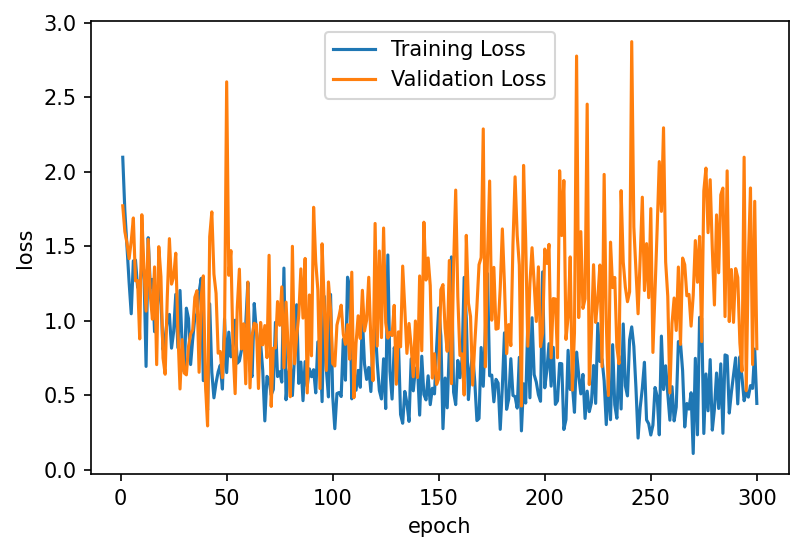

In [40]:
t_range = torch.arange(1, 301)

fig = plt.figure(dpi=150)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(t_range, torch.FloatTensor(test_2a[1]).cpu(), label='Training Loss')
plt.plot(t_range, torch.FloatTensor(test_2a[3]).cpu(), label='Validation Loss')
plt.legend()
plt.show()

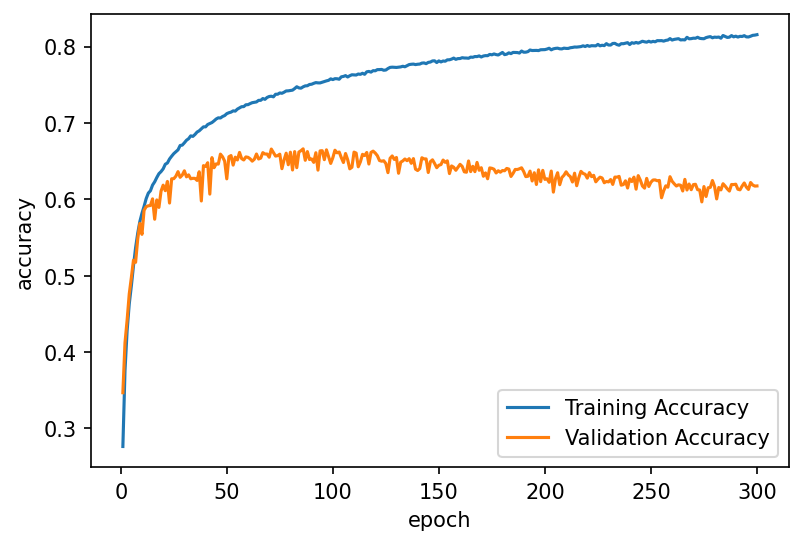

In [37]:
t_range = torch.arange(1, 301)

fig = plt.figure(dpi=150)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(t_range, torch.FloatTensor(test_2a[0]).cpu(), label='Training Accuracy')
plt.plot(t_range, torch.FloatTensor(test_2a[2]).cpu(), label='Validation Accuracy')
plt.legend()
plt.show()

In [38]:
numel_list = [p.numel() for p in model_1a.parameters()]
sum(numel_list), numel_list

(18354, [432, 16, 1152, 8, 16384, 32, 320, 10])

In [15]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * 8, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 10)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = F.max_pool2d(torch.tanh(self.conv3(out)), 2)
        
        out = out.view(-1, 4 * 4 * 8)
        out = torch.tanh(self.fc1(out))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

In [16]:
model_1b = Net()

numel_list = [p.numel() for p in model_1b.parameters()]
sum(numel_list), numel_list

(12226, [432, 16, 4608, 32, 2304, 8, 4096, 32, 512, 16, 160, 10])

In [17]:
print(torch.cuda.is_available())

True


In [18]:
model_1b = Net()  #  <2>
if torch.cuda.device_count() >= 1:
    model_1b = torch.nn.DataParallel(model_1b)
    device = torch.device("cuda")
    model_1b.to(device)
else:
    device='cpu'

In [19]:
learning_rate = 1e-2
optimizer = optim.SGD(model_1b.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 300

test_1b = training_loop(
    n_epochs = n_epochs, 
    optimizer = optimizer,
    model = model_1b,
    loss_fn = loss_fn,   
    dataloader = dataloaders,
    device = device,)

Epoch 1/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.26it/s]


train Loss: 2.1468 Acc: 0.1570 Time: 21.579724311828613


100%|██████████| 157/157 [00:03<00:00, 45.07it/s]


val Loss: 2.2720 Acc: 0.2150 Time: 3.4940528869628906
Epoch 2/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.18it/s]


train Loss: 1.8869 Acc: 0.2425 Time: 21.622930765151978


100%|██████████| 157/157 [00:03<00:00, 43.93it/s]


val Loss: 1.6836 Acc: 0.2693 Time: 3.590074300765991
Epoch 3/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.23it/s]


train Loss: 1.7604 Acc: 0.2836 Time: 21.59455704689026


100%|██████████| 157/157 [00:03<00:00, 44.43it/s]


val Loss: 2.0738 Acc: 0.3047 Time: 3.544750452041626
Epoch 4/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.51it/s]


train Loss: 1.8888 Acc: 0.3276 Time: 21.438640832901


100%|██████████| 157/157 [00:03<00:00, 42.79it/s]


val Loss: 1.5629 Acc: 0.3546 Time: 3.681166172027588
Epoch 5/300
----------


100%|██████████| 782/782 [00:28<00:00, 27.60it/s]


train Loss: 1.4975 Acc: 0.3740 Time: 28.339912176132202


100%|██████████| 157/157 [00:04<00:00, 34.24it/s]


val Loss: 1.7090 Acc: 0.3927 Time: 4.601640701293945
Epoch 6/300
----------


100%|██████████| 782/782 [00:26<00:00, 29.73it/s]


train Loss: 1.4663 Acc: 0.4057 Time: 26.310075283050537


100%|██████████| 157/157 [00:03<00:00, 44.46it/s]


val Loss: 1.7756 Acc: 0.4165 Time: 3.5439603328704834
Epoch 7/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.50it/s]


train Loss: 1.7827 Acc: 0.4407 Time: 21.437277793884277


100%|██████████| 157/157 [00:03<00:00, 43.66it/s]


val Loss: 1.5782 Acc: 0.4470 Time: 3.612330436706543
Epoch 8/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.77it/s]


train Loss: 1.4363 Acc: 0.4679 Time: 21.276617288589478


100%|██████████| 157/157 [00:03<00:00, 44.97it/s]


val Loss: 1.1197 Acc: 0.4344 Time: 3.503998279571533
Epoch 9/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.61it/s]


train Loss: 1.1842 Acc: 0.4898 Time: 21.379088401794434


100%|██████████| 157/157 [00:03<00:00, 41.95it/s]


val Loss: 1.4565 Acc: 0.4724 Time: 3.7527883052825928
Epoch 10/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.88it/s]


train Loss: 1.9814 Acc: 0.5066 Time: 21.810327291488647


100%|██████████| 157/157 [00:03<00:00, 40.94it/s]


val Loss: 1.6200 Acc: 0.5054 Time: 3.842083692550659
Epoch 11/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.60it/s]


train Loss: 1.4840 Acc: 0.5240 Time: 21.377589464187622


100%|██████████| 157/157 [00:03<00:00, 44.68it/s]


val Loss: 1.5248 Acc: 0.4938 Time: 3.5256941318511963
Epoch 12/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.52it/s]


train Loss: 1.2240 Acc: 0.5395 Time: 21.42354440689087


100%|██████████| 157/157 [00:03<00:00, 44.42it/s]


val Loss: 0.9767 Acc: 0.5480 Time: 3.544055938720703
Epoch 13/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.73it/s]


train Loss: 1.3713 Acc: 0.5534 Time: 21.900076627731323


100%|██████████| 157/157 [00:03<00:00, 44.90it/s]


val Loss: 0.8685 Acc: 0.5346 Time: 3.5088014602661133
Epoch 14/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.47it/s]


train Loss: 1.2320 Acc: 0.5673 Time: 21.45650577545166


100%|██████████| 157/157 [00:03<00:00, 44.13it/s]


val Loss: 0.6857 Acc: 0.5555 Time: 3.5709798336029053
Epoch 15/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.57it/s]


train Loss: 1.4719 Acc: 0.5793 Time: 21.3974871635437


100%|██████████| 157/157 [00:03<00:00, 44.82it/s]


val Loss: 1.5711 Acc: 0.5507 Time: 3.515986919403076
Epoch 16/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.62it/s]


train Loss: 0.9465 Acc: 0.5914 Time: 21.377031564712524


100%|██████████| 157/157 [00:03<00:00, 45.54it/s]


val Loss: 0.8845 Acc: 0.5364 Time: 3.45773983001709
Epoch 17/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.59it/s]


train Loss: 0.8839 Acc: 0.6002 Time: 21.38554096221924


100%|██████████| 157/157 [00:03<00:00, 44.98it/s]


val Loss: 1.0140 Acc: 0.5472 Time: 3.5022165775299072
Epoch 18/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.78it/s]


train Loss: 1.0335 Acc: 0.6074 Time: 21.27546000480652


100%|██████████| 157/157 [00:03<00:00, 44.90it/s]


val Loss: 1.6375 Acc: 0.5720 Time: 3.512624979019165
Epoch 19/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.89it/s]


train Loss: 1.4128 Acc: 0.6162 Time: 21.21500539779663


100%|██████████| 157/157 [00:03<00:00, 44.32it/s]


val Loss: 1.3568 Acc: 0.5959 Time: 3.552955389022827
Epoch 20/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.83it/s]


train Loss: 0.9414 Acc: 0.6248 Time: 21.23886251449585


100%|██████████| 157/157 [00:03<00:00, 45.35it/s]


val Loss: 0.9863 Acc: 0.5834 Time: 3.4765021800994873
Epoch 21/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.67it/s]


train Loss: 1.3723 Acc: 0.6326 Time: 21.33707618713379


100%|██████████| 157/157 [00:03<00:00, 44.85it/s]


val Loss: 1.0801 Acc: 0.6121 Time: 3.509516716003418
Epoch 22/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.75it/s]


train Loss: 1.3254 Acc: 0.6369 Time: 21.293212890625


100%|██████████| 157/157 [00:03<00:00, 45.31it/s]


val Loss: 1.1206 Acc: 0.5877 Time: 3.47891902923584
Epoch 23/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.87it/s]


train Loss: 1.0562 Acc: 0.6427 Time: 21.220048427581787


100%|██████████| 157/157 [00:03<00:00, 45.95it/s]


val Loss: 0.9408 Acc: 0.6099 Time: 3.4327800273895264
Epoch 24/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.83it/s]


train Loss: 0.9653 Acc: 0.6506 Time: 21.242347955703735


100%|██████████| 157/157 [00:03<00:00, 44.92it/s]


val Loss: 1.4176 Acc: 0.6311 Time: 3.5112051963806152
Epoch 25/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.62it/s]


train Loss: 1.1454 Acc: 0.6554 Time: 21.36073136329651


100%|██████████| 157/157 [00:03<00:00, 45.08it/s]


val Loss: 1.3664 Acc: 0.6363 Time: 3.496777057647705
Epoch 26/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.96it/s]


train Loss: 0.5572 Acc: 0.6596 Time: 21.172542333602905


100%|██████████| 157/157 [00:03<00:00, 44.18it/s]


val Loss: 1.2669 Acc: 0.6163 Time: 3.567333459854126
Epoch 27/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.72it/s]


train Loss: 0.4310 Acc: 0.6642 Time: 21.306293725967407


100%|██████████| 157/157 [00:03<00:00, 45.73it/s]


val Loss: 0.9931 Acc: 0.6487 Time: 3.445307493209839
Epoch 28/300
----------


100%|██████████| 782/782 [00:20<00:00, 37.29it/s]


train Loss: 0.7406 Acc: 0.6703 Time: 20.979735136032104


100%|██████████| 157/157 [00:03<00:00, 44.26it/s]


val Loss: 0.9595 Acc: 0.6493 Time: 3.5608224868774414
Epoch 29/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.84it/s]


train Loss: 0.9262 Acc: 0.6740 Time: 21.236286878585815


100%|██████████| 157/157 [00:03<00:00, 45.25it/s]


val Loss: 0.5842 Acc: 0.6481 Time: 3.487922430038452
Epoch 30/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.95it/s]


train Loss: 0.9539 Acc: 0.6778 Time: 21.183637380599976


100%|██████████| 157/157 [00:03<00:00, 44.97it/s]


val Loss: 0.7557 Acc: 0.6504 Time: 3.500094175338745
Epoch 31/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.82it/s]


train Loss: 1.0528 Acc: 0.6819 Time: 21.248229265213013


100%|██████████| 157/157 [00:03<00:00, 44.87it/s]


val Loss: 1.1517 Acc: 0.6342 Time: 3.5119922161102295
Epoch 32/300
----------


100%|██████████| 782/782 [00:21<00:00, 37.06it/s]


train Loss: 0.9893 Acc: 0.6838 Time: 21.109304189682007


100%|██████████| 157/157 [00:03<00:00, 43.70it/s]


val Loss: 1.1590 Acc: 0.6390 Time: 3.6082870960235596
Epoch 33/300
----------


100%|██████████| 782/782 [00:21<00:00, 37.10it/s]


train Loss: 0.5748 Acc: 0.6895 Time: 21.0896954536438


100%|██████████| 157/157 [00:03<00:00, 45.56it/s]


val Loss: 0.7489 Acc: 0.6434 Time: 3.4603848457336426
Epoch 34/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.83it/s]


train Loss: 0.9396 Acc: 0.6906 Time: 21.250713348388672


100%|██████████| 157/157 [00:03<00:00, 44.48it/s]


val Loss: 1.2289 Acc: 0.6308 Time: 3.541790008544922
Epoch 35/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.89it/s]


train Loss: 0.9603 Acc: 0.6946 Time: 21.214197158813477


100%|██████████| 157/157 [00:03<00:00, 46.32it/s]


val Loss: 0.9461 Acc: 0.6665 Time: 3.402221441268921
Epoch 36/300
----------


100%|██████████| 782/782 [00:21<00:00, 37.02it/s]


train Loss: 0.6674 Acc: 0.6981 Time: 21.13235902786255


100%|██████████| 157/157 [00:03<00:00, 44.71it/s]


val Loss: 1.5272 Acc: 0.6652 Time: 3.520509719848633
Epoch 37/300
----------


100%|██████████| 782/782 [00:21<00:00, 37.04it/s]


train Loss: 1.1173 Acc: 0.7010 Time: 21.121163845062256


100%|██████████| 157/157 [00:03<00:00, 44.65it/s]


val Loss: 0.8817 Acc: 0.6443 Time: 3.5291051864624023
Epoch 38/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.57it/s]


train Loss: 0.8674 Acc: 0.7028 Time: 21.39953374862671


100%|██████████| 157/157 [00:03<00:00, 44.19it/s]


val Loss: 0.9858 Acc: 0.6566 Time: 3.566206932067871
Epoch 39/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.06it/s]


train Loss: 0.8035 Acc: 0.7073 Time: 21.698895692825317


100%|██████████| 157/157 [00:03<00:00, 44.50it/s]


val Loss: 1.2115 Acc: 0.6750 Time: 3.5395514965057373
Epoch 40/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.52it/s]


train Loss: 0.8191 Acc: 0.7095 Time: 21.426670789718628


100%|██████████| 157/157 [00:03<00:00, 45.19it/s]


val Loss: 0.8840 Acc: 0.6723 Time: 3.4900074005126953
Epoch 41/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.71it/s]


train Loss: 1.0725 Acc: 0.7109 Time: 21.311232566833496


100%|██████████| 157/157 [00:03<00:00, 45.34it/s]


val Loss: 0.9305 Acc: 0.6683 Time: 3.4719133377075195
Epoch 42/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.68it/s]


train Loss: 0.7874 Acc: 0.7136 Time: 21.331379175186157


100%|██████████| 157/157 [00:03<00:00, 44.26it/s]


val Loss: 1.1680 Acc: 0.6553 Time: 3.561875104904175
Epoch 43/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.62it/s]


train Loss: 0.6872 Acc: 0.7168 Time: 21.365302562713623


100%|██████████| 157/157 [00:03<00:00, 43.68it/s]


val Loss: 1.7411 Acc: 0.6523 Time: 3.6033802032470703
Epoch 44/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.45it/s]


train Loss: 1.1047 Acc: 0.7185 Time: 21.465675115585327


100%|██████████| 157/157 [00:03<00:00, 43.82it/s]


val Loss: 0.5838 Acc: 0.6422 Time: 3.593444347381592
Epoch 45/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.64it/s]


train Loss: 0.8668 Acc: 0.7204 Time: 21.35409641265869


100%|██████████| 157/157 [00:03<00:00, 44.33it/s]


val Loss: 1.1535 Acc: 0.6455 Time: 3.5529468059539795
Epoch 46/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.53it/s]


train Loss: 0.9431 Acc: 0.7195 Time: 21.418390035629272


100%|██████████| 157/157 [00:03<00:00, 44.71it/s]


val Loss: 1.0219 Acc: 0.6604 Time: 3.526639699935913
Epoch 47/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.49it/s]


train Loss: 0.3828 Acc: 0.7219 Time: 21.43860650062561


100%|██████████| 157/157 [00:03<00:00, 44.18it/s]


val Loss: 1.4034 Acc: 0.6561 Time: 3.566770076751709
Epoch 48/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.93it/s]


train Loss: 0.8405 Acc: 0.7244 Time: 21.183738231658936


100%|██████████| 157/157 [00:03<00:00, 44.78it/s]


val Loss: 0.8364 Acc: 0.6653 Time: 3.5223517417907715
Epoch 49/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.35it/s]


train Loss: 0.5352 Acc: 0.7256 Time: 21.52046799659729


100%|██████████| 157/157 [00:03<00:00, 44.56it/s]


val Loss: 0.9109 Acc: 0.6510 Time: 3.5433566570281982
Epoch 50/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.52it/s]


train Loss: 0.5718 Acc: 0.7294 Time: 21.431942462921143


100%|██████████| 157/157 [00:03<00:00, 44.35it/s]


val Loss: 0.8899 Acc: 0.6636 Time: 3.5485434532165527
Epoch 51/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.11it/s]


train Loss: 0.7921 Acc: 0.7304 Time: 21.673442125320435


100%|██████████| 157/157 [00:03<00:00, 44.28it/s]


val Loss: 1.0335 Acc: 0.6612 Time: 3.556370258331299
Epoch 52/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.65it/s]


train Loss: 0.8389 Acc: 0.7308 Time: 21.346829175949097


100%|██████████| 157/157 [00:03<00:00, 44.36it/s]


val Loss: 0.6585 Acc: 0.6541 Time: 3.555243492126465
Epoch 53/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.22it/s]


train Loss: 0.6694 Acc: 0.7340 Time: 21.60077452659607


100%|██████████| 157/157 [00:03<00:00, 45.22it/s]


val Loss: 1.2686 Acc: 0.6833 Time: 3.485952615737915
Epoch 54/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.30it/s]


train Loss: 0.8784 Acc: 0.7349 Time: 21.564679622650146


100%|██████████| 157/157 [00:03<00:00, 44.02it/s]


val Loss: 0.3672 Acc: 0.6816 Time: 3.5781002044677734
Epoch 55/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.53it/s]


train Loss: 1.1072 Acc: 0.7366 Time: 21.418829202651978


100%|██████████| 157/157 [00:03<00:00, 44.45it/s]


val Loss: 0.8920 Acc: 0.6799 Time: 3.548602342605591
Epoch 56/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.69it/s]


train Loss: 0.9849 Acc: 0.7363 Time: 21.325148820877075


100%|██████████| 157/157 [00:03<00:00, 43.65it/s]


val Loss: 0.6666 Acc: 0.6795 Time: 3.6136605739593506
Epoch 57/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.82it/s]


train Loss: 0.4786 Acc: 0.7382 Time: 21.25395703315735


100%|██████████| 157/157 [00:03<00:00, 44.61it/s]


val Loss: 1.4193 Acc: 0.6747 Time: 3.5348262786865234
Epoch 58/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.37it/s]


train Loss: 0.6887 Acc: 0.7413 Time: 21.520046710968018


100%|██████████| 157/157 [00:03<00:00, 44.22it/s]


val Loss: 1.1497 Acc: 0.6870 Time: 3.5649707317352295
Epoch 59/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.76it/s]


train Loss: 0.4402 Acc: 0.7392 Time: 21.283605813980103


100%|██████████| 157/157 [00:03<00:00, 44.74it/s]


val Loss: 0.7934 Acc: 0.6786 Time: 3.515777349472046
Epoch 60/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.65it/s]


train Loss: 0.6031 Acc: 0.7432 Time: 21.346012830734253


100%|██████████| 157/157 [00:03<00:00, 45.14it/s]


val Loss: 0.7051 Acc: 0.6815 Time: 3.4950053691864014
Epoch 61/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.53it/s]


train Loss: 0.5084 Acc: 0.7431 Time: 21.42668080329895


100%|██████████| 157/157 [00:03<00:00, 44.43it/s]


val Loss: 0.6283 Acc: 0.6711 Time: 3.539154291152954
Epoch 62/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.96it/s]


train Loss: 0.9256 Acc: 0.7461 Time: 21.166584491729736


100%|██████████| 157/157 [00:03<00:00, 43.81it/s]


val Loss: 1.2079 Acc: 0.6458 Time: 3.5973684787750244
Epoch 63/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.57it/s]


train Loss: 0.8132 Acc: 0.7448 Time: 21.395745277404785


100%|██████████| 157/157 [00:03<00:00, 44.69it/s]


val Loss: 1.2080 Acc: 0.6753 Time: 3.5210678577423096
Epoch 64/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.62it/s]


train Loss: 0.4114 Acc: 0.7482 Time: 21.362592935562134


100%|██████████| 157/157 [00:03<00:00, 45.44it/s]


val Loss: 1.0918 Acc: 0.6652 Time: 3.4679102897644043
Epoch 65/300
----------


100%|██████████| 782/782 [00:21<00:00, 37.01it/s]


train Loss: 0.7972 Acc: 0.7483 Time: 21.137441635131836


100%|██████████| 157/157 [00:03<00:00, 44.39it/s]


val Loss: 0.8643 Acc: 0.6519 Time: 3.5506930351257324
Epoch 66/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.77it/s]


train Loss: 0.4497 Acc: 0.7503 Time: 21.274043321609497


100%|██████████| 157/157 [00:03<00:00, 44.63it/s]


val Loss: 0.3474 Acc: 0.6832 Time: 3.534559726715088
Epoch 67/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.57it/s]


train Loss: 0.5302 Acc: 0.7505 Time: 21.39403223991394


100%|██████████| 157/157 [00:03<00:00, 43.75it/s]


val Loss: 1.1563 Acc: 0.6652 Time: 3.6025476455688477
Epoch 68/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.74it/s]


train Loss: 0.5046 Acc: 0.7513 Time: 21.29627299308777


100%|██████████| 157/157 [00:03<00:00, 45.35it/s]


val Loss: 0.6875 Acc: 0.6768 Time: 3.472043991088867
Epoch 69/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.54it/s]


train Loss: 0.5803 Acc: 0.7525 Time: 21.411372900009155


100%|██████████| 157/157 [00:03<00:00, 44.76it/s]


val Loss: 0.9562 Acc: 0.6601 Time: 3.522627353668213
Epoch 70/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.52it/s]


train Loss: 0.7300 Acc: 0.7537 Time: 21.434348106384277


100%|██████████| 157/157 [00:03<00:00, 43.43it/s]


val Loss: 0.7640 Acc: 0.6839 Time: 3.6217806339263916
Epoch 71/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.31it/s]


train Loss: 1.0118 Acc: 0.7535 Time: 21.548537254333496


100%|██████████| 157/157 [00:03<00:00, 45.16it/s]


val Loss: 1.2137 Acc: 0.6479 Time: 3.484651803970337
Epoch 72/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.61it/s]


train Loss: 0.6303 Acc: 0.7566 Time: 21.366225004196167


100%|██████████| 157/157 [00:03<00:00, 44.18it/s]


val Loss: 1.0758 Acc: 0.6598 Time: 3.5616581439971924
Epoch 73/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.59it/s]


train Loss: 1.0626 Acc: 0.7556 Time: 21.381868362426758


100%|██████████| 157/157 [00:03<00:00, 44.03it/s]


val Loss: 1.2659 Acc: 0.6713 Time: 3.5781514644622803
Epoch 74/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.78it/s]


train Loss: 0.4802 Acc: 0.7569 Time: 21.27278208732605


100%|██████████| 157/157 [00:03<00:00, 44.08it/s]


val Loss: 1.1297 Acc: 0.6846 Time: 3.5737550258636475
Epoch 75/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.69it/s]


train Loss: 0.6760 Acc: 0.7583 Time: 21.32930874824524


100%|██████████| 157/157 [00:03<00:00, 44.93it/s]


val Loss: 1.6347 Acc: 0.6883 Time: 3.5141873359680176
Epoch 76/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.51it/s]


train Loss: 1.2016 Acc: 0.7595 Time: 21.43239736557007


100%|██████████| 157/157 [00:03<00:00, 44.34it/s]


val Loss: 0.4481 Acc: 0.6914 Time: 3.555860996246338
Epoch 77/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.47it/s]


train Loss: 0.7986 Acc: 0.7623 Time: 21.453707933425903


100%|██████████| 157/157 [00:03<00:00, 44.46it/s]


val Loss: 0.6815 Acc: 0.6762 Time: 3.5421741008758545
Epoch 78/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.79it/s]


train Loss: 0.4553 Acc: 0.7617 Time: 21.26398777961731


100%|██████████| 157/157 [00:03<00:00, 44.24it/s]


val Loss: 0.7783 Acc: 0.6818 Time: 3.5600082874298096
Epoch 79/300
----------


100%|██████████| 782/782 [00:21<00:00, 37.23it/s]


train Loss: 0.5278 Acc: 0.7622 Time: 21.01682448387146


100%|██████████| 157/157 [00:03<00:00, 45.54it/s]


val Loss: 1.2554 Acc: 0.6856 Time: 3.4550204277038574
Epoch 80/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.89it/s]


train Loss: 0.6500 Acc: 0.7632 Time: 21.20838475227356


100%|██████████| 157/157 [00:03<00:00, 43.67it/s]


val Loss: 0.8367 Acc: 0.6629 Time: 3.6106531620025635
Epoch 81/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.98it/s]


train Loss: 0.6711 Acc: 0.7642 Time: 21.157286167144775


100%|██████████| 157/157 [00:03<00:00, 44.93it/s]


val Loss: 1.3417 Acc: 0.6654 Time: 3.50740122795105
Epoch 82/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.86it/s]


train Loss: 0.6517 Acc: 0.7633 Time: 21.22912287712097


100%|██████████| 157/157 [00:03<00:00, 44.60it/s]


val Loss: 1.0926 Acc: 0.6898 Time: 3.5320353507995605
Epoch 83/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.81it/s]


train Loss: 0.9199 Acc: 0.7660 Time: 21.25511908531189


100%|██████████| 157/157 [00:03<00:00, 44.97it/s]


val Loss: 0.8591 Acc: 0.6681 Time: 3.4986231327056885
Epoch 84/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.49it/s]


train Loss: 0.6627 Acc: 0.7659 Time: 21.435338020324707


100%|██████████| 157/157 [00:03<00:00, 44.98it/s]


val Loss: 0.8280 Acc: 0.6854 Time: 3.505096912384033
Epoch 85/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.80it/s]


train Loss: 0.4043 Acc: 0.7681 Time: 21.26326084136963


100%|██████████| 157/157 [00:03<00:00, 44.37it/s]


val Loss: 0.7641 Acc: 0.6857 Time: 3.548426628112793
Epoch 86/300
----------


100%|██████████| 782/782 [00:21<00:00, 37.12it/s]


train Loss: 0.4642 Acc: 0.7673 Time: 21.077799558639526


100%|██████████| 157/157 [00:03<00:00, 44.67it/s]


val Loss: 0.7937 Acc: 0.6934 Time: 3.5307302474975586
Epoch 87/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.83it/s]


train Loss: 0.4979 Acc: 0.7698 Time: 21.24246072769165


100%|██████████| 157/157 [00:03<00:00, 44.60it/s]


val Loss: 1.4106 Acc: 0.6254 Time: 3.532254695892334
Epoch 88/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.61it/s]


train Loss: 0.8652 Acc: 0.7700 Time: 21.366660356521606


100%|██████████| 157/157 [00:03<00:00, 44.06it/s]


val Loss: 1.0680 Acc: 0.6807 Time: 3.5784990787506104
Epoch 89/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.61it/s]


train Loss: 0.7831 Acc: 0.7689 Time: 21.36629557609558


100%|██████████| 157/157 [00:03<00:00, 43.97it/s]


val Loss: 1.0702 Acc: 0.6798 Time: 3.582047939300537
Epoch 90/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.72it/s]


train Loss: 0.2843 Acc: 0.7692 Time: 21.30704116821289


100%|██████████| 157/157 [00:03<00:00, 44.82it/s]


val Loss: 0.8900 Acc: 0.6849 Time: 3.519118309020996
Epoch 91/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.26it/s]


train Loss: 0.6053 Acc: 0.7725 Time: 21.581281661987305


100%|██████████| 157/157 [00:03<00:00, 43.97it/s]


val Loss: 1.1259 Acc: 0.6901 Time: 3.586169481277466
Epoch 92/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.56it/s]


train Loss: 0.4865 Acc: 0.7722 Time: 21.405967235565186


100%|██████████| 157/157 [00:03<00:00, 44.27it/s]


val Loss: 0.6645 Acc: 0.6671 Time: 3.5583930015563965
Epoch 93/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.96it/s]


train Loss: 0.2893 Acc: 0.7724 Time: 21.167754888534546


100%|██████████| 157/157 [00:03<00:00, 44.52it/s]


val Loss: 0.4267 Acc: 0.6892 Time: 3.5379843711853027
Epoch 94/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.68it/s]


train Loss: 0.8921 Acc: 0.7720 Time: 21.3264582157135


100%|██████████| 157/157 [00:03<00:00, 45.06it/s]


val Loss: 1.2656 Acc: 0.6691 Time: 3.497328996658325
Epoch 95/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.54it/s]


train Loss: 0.9723 Acc: 0.7749 Time: 21.40682601928711


100%|██████████| 157/157 [00:03<00:00, 45.14it/s]


val Loss: 0.6921 Acc: 0.6812 Time: 3.49139142036438
Epoch 96/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.91it/s]


train Loss: 1.0303 Acc: 0.7755 Time: 21.195942401885986


100%|██████████| 157/157 [00:03<00:00, 44.87it/s]


val Loss: 1.0437 Acc: 0.6592 Time: 3.505934000015259
Epoch 97/300
----------


100%|██████████| 782/782 [00:21<00:00, 37.15it/s]


train Loss: 0.6843 Acc: 0.7756 Time: 21.06196689605713


100%|██████████| 157/157 [00:03<00:00, 45.62it/s]


val Loss: 0.7936 Acc: 0.6694 Time: 3.4514429569244385
Epoch 98/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.86it/s]


train Loss: 0.6258 Acc: 0.7766 Time: 21.22457790374756


100%|██████████| 157/157 [00:03<00:00, 45.30it/s]


val Loss: 1.2930 Acc: 0.6757 Time: 3.473320722579956
Epoch 99/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.74it/s]


train Loss: 0.2610 Acc: 0.7740 Time: 21.291955709457397


100%|██████████| 157/157 [00:03<00:00, 44.38it/s]


val Loss: 0.5761 Acc: 0.6817 Time: 3.5521903038024902
Epoch 100/300
----------


100%|██████████| 782/782 [00:21<00:00, 37.04it/s]


train Loss: 0.6319 Acc: 0.7766 Time: 21.130958318710327


100%|██████████| 157/157 [00:03<00:00, 44.91it/s]


val Loss: 1.2984 Acc: 0.6866 Time: 3.5093297958374023
Epoch 101/300
----------


100%|██████████| 782/782 [00:21<00:00, 37.00it/s]


train Loss: 0.8912 Acc: 0.7764 Time: 21.140886783599854


100%|██████████| 157/157 [00:03<00:00, 43.87it/s]


val Loss: 0.6990 Acc: 0.6875 Time: 3.595534086227417
Epoch 102/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.91it/s]


train Loss: 0.5916 Acc: 0.7767 Time: 21.196183443069458


100%|██████████| 157/157 [00:03<00:00, 45.55it/s]


val Loss: 1.4869 Acc: 0.6706 Time: 3.4554972648620605
Epoch 103/300
----------


100%|██████████| 782/782 [00:21<00:00, 37.24it/s]


train Loss: 1.0715 Acc: 0.7770 Time: 21.007585287094116


100%|██████████| 157/157 [00:03<00:00, 43.97it/s]


val Loss: 1.0839 Acc: 0.6595 Time: 3.5883378982543945
Epoch 104/300
----------


100%|██████████| 782/782 [00:21<00:00, 37.17it/s]


train Loss: 0.3187 Acc: 0.7802 Time: 21.054537773132324


100%|██████████| 157/157 [00:03<00:00, 45.21it/s]


val Loss: 0.7127 Acc: 0.6859 Time: 3.4900195598602295
Epoch 105/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.60it/s]


train Loss: 0.6746 Acc: 0.7787 Time: 21.384526014328003


100%|██████████| 157/157 [00:03<00:00, 45.12it/s]


val Loss: 0.5418 Acc: 0.6821 Time: 3.4888851642608643
Epoch 106/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.61it/s]


train Loss: 0.5547 Acc: 0.7797 Time: 21.371597290039062


100%|██████████| 157/157 [00:03<00:00, 44.57it/s]


val Loss: 0.8321 Acc: 0.6878 Time: 3.530735969543457
Epoch 107/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.86it/s]


train Loss: 0.7734 Acc: 0.7799 Time: 21.229036808013916


100%|██████████| 157/157 [00:03<00:00, 44.41it/s]


val Loss: 1.4602 Acc: 0.6452 Time: 3.549363613128662
Epoch 108/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.97it/s]


train Loss: 0.3555 Acc: 0.7784 Time: 21.15914559364319


100%|██████████| 157/157 [00:03<00:00, 45.39it/s]


val Loss: 0.8130 Acc: 0.6735 Time: 3.4721109867095947
Epoch 109/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.09it/s]


train Loss: 1.0252 Acc: 0.7814 Time: 21.675577402114868


100%|██████████| 157/157 [00:03<00:00, 44.34it/s]


val Loss: 0.6549 Acc: 0.6620 Time: 3.5543766021728516
Epoch 110/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.46it/s]


train Loss: 0.7475 Acc: 0.7805 Time: 21.460468769073486


100%|██████████| 157/157 [00:03<00:00, 44.59it/s]


val Loss: 1.2730 Acc: 0.6657 Time: 3.5287132263183594
Epoch 111/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.03it/s]


train Loss: 0.4910 Acc: 0.7811 Time: 21.71297025680542


100%|██████████| 157/157 [00:03<00:00, 43.62it/s]


val Loss: 0.8362 Acc: 0.6722 Time: 3.6153266429901123
Epoch 112/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.27it/s]


train Loss: 0.5897 Acc: 0.7812 Time: 21.56925654411316


100%|██████████| 157/157 [00:03<00:00, 43.94it/s]


val Loss: 0.7748 Acc: 0.6652 Time: 3.5913360118865967
Epoch 113/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.20it/s]


train Loss: 0.6437 Acc: 0.7823 Time: 21.605554342269897


100%|██████████| 157/157 [00:03<00:00, 44.16it/s]


val Loss: 0.5203 Acc: 0.6880 Time: 3.5675923824310303
Epoch 114/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.48it/s]


train Loss: 0.5229 Acc: 0.7833 Time: 21.44661808013916


100%|██████████| 157/157 [00:03<00:00, 44.57it/s]


val Loss: 0.8205 Acc: 0.6775 Time: 3.533463954925537
Epoch 115/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.59it/s]


train Loss: 0.5246 Acc: 0.7829 Time: 21.394887924194336


100%|██████████| 157/157 [00:03<00:00, 44.38it/s]


val Loss: 0.7941 Acc: 0.6868 Time: 3.5457723140716553
Epoch 116/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.33it/s]


train Loss: 0.3957 Acc: 0.7829 Time: 21.53734517097473


100%|██████████| 157/157 [00:03<00:00, 43.79it/s]


val Loss: 1.3033 Acc: 0.6665 Time: 3.599632740020752
Epoch 117/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.11it/s]


train Loss: 0.4174 Acc: 0.7858 Time: 21.67035484313965


100%|██████████| 157/157 [00:03<00:00, 44.31it/s]


val Loss: 1.3419 Acc: 0.6688 Time: 3.558053493499756
Epoch 118/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.27it/s]


train Loss: 0.3430 Acc: 0.7864 Time: 21.569686889648438


100%|██████████| 157/157 [00:03<00:00, 44.93it/s]


val Loss: 0.7763 Acc: 0.6760 Time: 3.507612466812134
Epoch 119/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.47it/s]


train Loss: 0.8262 Acc: 0.7863 Time: 21.459914445877075


100%|██████████| 157/157 [00:03<00:00, 43.70it/s]


val Loss: 1.4437 Acc: 0.5984 Time: 3.599858045578003
Epoch 120/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.25it/s]


train Loss: 0.6147 Acc: 0.7863 Time: 21.582077264785767


100%|██████████| 157/157 [00:03<00:00, 44.30it/s]


val Loss: 1.4041 Acc: 0.6694 Time: 3.5532870292663574
Epoch 121/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.66it/s]


train Loss: 0.4064 Acc: 0.7867 Time: 21.346779108047485


100%|██████████| 157/157 [00:03<00:00, 43.86it/s]


val Loss: 0.6074 Acc: 0.6874 Time: 3.598055839538574
Epoch 122/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.50it/s]


train Loss: 0.6446 Acc: 0.7863 Time: 21.43172836303711


100%|██████████| 157/157 [00:03<00:00, 44.16it/s]


val Loss: 0.7945 Acc: 0.6774 Time: 3.567068338394165
Epoch 123/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.32it/s]


train Loss: 0.6230 Acc: 0.7864 Time: 21.53725028038025


100%|██████████| 157/157 [00:03<00:00, 44.77it/s]


val Loss: 0.7960 Acc: 0.6557 Time: 3.522660732269287
Epoch 124/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.37it/s]


train Loss: 0.8550 Acc: 0.7870 Time: 21.512888431549072


100%|██████████| 157/157 [00:03<00:00, 44.45it/s]


val Loss: 1.0476 Acc: 0.6619 Time: 3.5466127395629883
Epoch 125/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.60it/s]


train Loss: 0.5414 Acc: 0.7874 Time: 21.371889352798462


100%|██████████| 157/157 [00:03<00:00, 43.97it/s]


val Loss: 0.9335 Acc: 0.6781 Time: 3.5817935466766357
Epoch 126/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.99it/s]


train Loss: 0.4496 Acc: 0.7874 Time: 21.746174812316895


100%|██████████| 157/157 [00:03<00:00, 43.81it/s]


val Loss: 1.1713 Acc: 0.6754 Time: 3.594822406768799
Epoch 127/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.35it/s]


train Loss: 0.8269 Acc: 0.7882 Time: 21.526018381118774


100%|██████████| 157/157 [00:03<00:00, 44.37it/s]


val Loss: 0.9282 Acc: 0.6476 Time: 3.552954912185669
Epoch 128/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.33it/s]


train Loss: 0.7392 Acc: 0.7876 Time: 21.53400492668152


100%|██████████| 157/157 [00:03<00:00, 44.16it/s]


val Loss: 1.6662 Acc: 0.6546 Time: 3.5702602863311768
Epoch 129/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.97it/s]


train Loss: 0.3785 Acc: 0.7907 Time: 21.756767749786377


100%|██████████| 157/157 [00:03<00:00, 44.22it/s]


val Loss: 0.9685 Acc: 0.6794 Time: 3.5598433017730713
Epoch 130/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.22it/s]


train Loss: 0.5644 Acc: 0.7905 Time: 21.603584051132202


100%|██████████| 157/157 [00:03<00:00, 43.84it/s]


val Loss: 0.5521 Acc: 0.6752 Time: 3.5968947410583496
Epoch 131/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.13it/s]


train Loss: 0.9918 Acc: 0.7911 Time: 21.658369302749634


100%|██████████| 157/157 [00:03<00:00, 43.95it/s]


val Loss: 1.0075 Acc: 0.6634 Time: 3.592507839202881
Epoch 132/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.23it/s]


train Loss: 0.5221 Acc: 0.7894 Time: 21.595916748046875


100%|██████████| 157/157 [00:03<00:00, 43.96it/s]


val Loss: 0.8989 Acc: 0.6713 Time: 3.5865118503570557
Epoch 133/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.46it/s]


train Loss: 0.8087 Acc: 0.7901 Time: 21.46220827102661


100%|██████████| 157/157 [00:03<00:00, 43.94it/s]


val Loss: 1.0272 Acc: 0.6532 Time: 3.585963726043701
Epoch 134/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.51it/s]


train Loss: 0.4776 Acc: 0.7896 Time: 21.42971920967102


100%|██████████| 157/157 [00:03<00:00, 43.52it/s]


val Loss: 1.3107 Acc: 0.6726 Time: 3.6224679946899414
Epoch 135/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.41it/s]


train Loss: 0.5890 Acc: 0.7910 Time: 21.495333909988403


100%|██████████| 157/157 [00:03<00:00, 45.26it/s]


val Loss: 0.9989 Acc: 0.6632 Time: 3.479346513748169
Epoch 136/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.47it/s]


train Loss: 0.3827 Acc: 0.7916 Time: 21.454933881759644


100%|██████████| 157/157 [00:03<00:00, 44.91it/s]


val Loss: 1.0197 Acc: 0.6823 Time: 3.503305673599243
Epoch 137/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.32it/s]


train Loss: 0.4952 Acc: 0.7923 Time: 21.537086009979248


100%|██████████| 157/157 [00:03<00:00, 43.70it/s]


val Loss: 1.6643 Acc: 0.6750 Time: 3.607140302658081
Epoch 138/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.67it/s]


train Loss: 0.7190 Acc: 0.7916 Time: 21.334293127059937


100%|██████████| 157/157 [00:03<00:00, 44.21it/s]


val Loss: 1.3389 Acc: 0.6588 Time: 3.5642249584198
Epoch 139/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.33it/s]


train Loss: 0.6879 Acc: 0.7923 Time: 21.53835105895996


100%|██████████| 157/157 [00:03<00:00, 45.32it/s]


val Loss: 1.3855 Acc: 0.6571 Time: 3.478391408920288
Epoch 140/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.29it/s]


train Loss: 0.6550 Acc: 0.7921 Time: 21.558459997177124


100%|██████████| 157/157 [00:03<00:00, 44.56it/s]


val Loss: 0.9816 Acc: 0.6807 Time: 3.5416572093963623
Epoch 141/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.63it/s]


train Loss: 0.4746 Acc: 0.7922 Time: 21.360038995742798


100%|██████████| 157/157 [00:03<00:00, 44.15it/s]


val Loss: 0.9046 Acc: 0.6802 Time: 3.5639140605926514
Epoch 142/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.46it/s]


train Loss: 0.3687 Acc: 0.7947 Time: 21.464543342590332


100%|██████████| 157/157 [00:03<00:00, 45.14it/s]


val Loss: 1.0031 Acc: 0.6665 Time: 3.489767551422119
Epoch 143/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.67it/s]


train Loss: 0.4778 Acc: 0.7947 Time: 21.336924076080322


100%|██████████| 157/157 [00:03<00:00, 43.97it/s]


val Loss: 1.0675 Acc: 0.6743 Time: 3.586071252822876
Epoch 144/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.67it/s]


train Loss: 0.4722 Acc: 0.7943 Time: 21.3344943523407


100%|██████████| 157/157 [00:03<00:00, 43.71it/s]


val Loss: 0.8511 Acc: 0.6535 Time: 3.599113702774048
Epoch 145/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.43it/s]


train Loss: 0.6545 Acc: 0.7937 Time: 21.472307682037354


100%|██████████| 157/157 [00:03<00:00, 43.98it/s]


val Loss: 1.0255 Acc: 0.6380 Time: 3.5785024166107178
Epoch 146/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.49it/s]


train Loss: 0.6056 Acc: 0.7945 Time: 21.44531750679016


100%|██████████| 157/157 [00:03<00:00, 44.36it/s]


val Loss: 0.4896 Acc: 0.6819 Time: 3.552835702896118
Epoch 147/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.66it/s]


train Loss: 0.7354 Acc: 0.7950 Time: 21.339888095855713


100%|██████████| 157/157 [00:03<00:00, 44.38it/s]


val Loss: 1.4042 Acc: 0.6534 Time: 3.548495054244995
Epoch 148/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.48it/s]


train Loss: 0.7476 Acc: 0.7950 Time: 21.451295614242554


100%|██████████| 157/157 [00:03<00:00, 44.17it/s]


val Loss: 1.6496 Acc: 0.6715 Time: 3.5659613609313965
Epoch 149/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.51it/s]


train Loss: 0.2856 Acc: 0.7948 Time: 21.432130575180054


100%|██████████| 157/157 [00:03<00:00, 44.46it/s]


val Loss: 1.5947 Acc: 0.6744 Time: 3.5493791103363037
Epoch 150/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.39it/s]


train Loss: 0.4287 Acc: 0.7950 Time: 21.506969451904297


100%|██████████| 157/157 [00:03<00:00, 44.26it/s]


val Loss: 1.7593 Acc: 0.6630 Time: 3.5615458488464355
Epoch 151/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.14it/s]


train Loss: 0.7495 Acc: 0.7968 Time: 21.649354934692383


100%|██████████| 157/157 [00:03<00:00, 45.13it/s]


val Loss: 0.8549 Acc: 0.6619 Time: 3.495819091796875
Epoch 152/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.30it/s]


train Loss: 0.2663 Acc: 0.7966 Time: 21.551595211029053


100%|██████████| 157/157 [00:03<00:00, 44.98it/s]


val Loss: 1.3566 Acc: 0.6796 Time: 3.50363826751709
Epoch 153/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.64it/s]


train Loss: 0.3449 Acc: 0.7973 Time: 21.34898042678833


100%|██████████| 157/157 [00:03<00:00, 44.83it/s]


val Loss: 1.1771 Acc: 0.6680 Time: 3.5133421421051025
Epoch 154/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.11it/s]


train Loss: 0.5095 Acc: 0.7966 Time: 21.67332887649536


100%|██████████| 157/157 [00:03<00:00, 44.01it/s]


val Loss: 0.8154 Acc: 0.6661 Time: 3.582200288772583
Epoch 155/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.34it/s]


train Loss: 0.4506 Acc: 0.7972 Time: 21.525360822677612


100%|██████████| 157/157 [00:03<00:00, 43.99it/s]


val Loss: 1.0407 Acc: 0.6727 Time: 3.5823538303375244
Epoch 156/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.47it/s]


train Loss: 0.3610 Acc: 0.7971 Time: 21.45184087753296


100%|██████████| 157/157 [00:03<00:00, 44.03it/s]


val Loss: 0.6474 Acc: 0.6776 Time: 3.5751919746398926
Epoch 157/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.46it/s]


train Loss: 0.9318 Acc: 0.7969 Time: 21.46284031867981


100%|██████████| 157/157 [00:03<00:00, 45.02it/s]


val Loss: 0.7279 Acc: 0.6761 Time: 3.495094060897827
Epoch 158/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.49it/s]


train Loss: 0.6184 Acc: 0.8000 Time: 21.4433696269989


100%|██████████| 157/157 [00:03<00:00, 44.49it/s]


val Loss: 1.3367 Acc: 0.6448 Time: 3.540949583053589
Epoch 159/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.23it/s]


train Loss: 0.4095 Acc: 0.7988 Time: 21.595460891723633


100%|██████████| 157/157 [00:03<00:00, 44.35it/s]


val Loss: 1.2190 Acc: 0.6701 Time: 3.5548505783081055
Epoch 160/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.36it/s]


train Loss: 0.3583 Acc: 0.7995 Time: 21.51983642578125


100%|██████████| 157/157 [00:03<00:00, 44.57it/s]


val Loss: 0.9451 Acc: 0.6558 Time: 3.5367565155029297
Epoch 161/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.42it/s]


train Loss: 0.4754 Acc: 0.8002 Time: 21.488834857940674


100%|██████████| 157/157 [00:03<00:00, 44.58it/s]


val Loss: 1.3404 Acc: 0.6639 Time: 3.528996229171753
Epoch 162/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.33it/s]


train Loss: 0.6199 Acc: 0.7999 Time: 21.538372039794922


100%|██████████| 157/157 [00:03<00:00, 45.08it/s]


val Loss: 0.5389 Acc: 0.6656 Time: 3.4907009601593018
Epoch 163/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.16it/s]


train Loss: 0.5953 Acc: 0.7987 Time: 21.646621704101562


100%|██████████| 157/157 [00:03<00:00, 43.74it/s]


val Loss: 1.1057 Acc: 0.6554 Time: 3.5977213382720947
Epoch 164/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.30it/s]


train Loss: 0.4713 Acc: 0.8001 Time: 21.552057027816772


100%|██████████| 157/157 [00:03<00:00, 43.82it/s]


val Loss: 1.6607 Acc: 0.6672 Time: 3.596769094467163
Epoch 165/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.15it/s]


train Loss: 0.3094 Acc: 0.7992 Time: 21.644287824630737


100%|██████████| 157/157 [00:03<00:00, 44.14it/s]


val Loss: 1.5419 Acc: 0.6564 Time: 3.568460464477539
Epoch 166/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.29it/s]


train Loss: 0.5176 Acc: 0.8006 Time: 21.557437658309937


100%|██████████| 157/157 [00:03<00:00, 44.98it/s]


val Loss: 0.8502 Acc: 0.6627 Time: 3.5057480335235596
Epoch 167/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.64it/s]


train Loss: 0.6306 Acc: 0.7999 Time: 21.362042665481567


100%|██████████| 157/157 [00:03<00:00, 44.94it/s]


val Loss: 0.8151 Acc: 0.6689 Time: 3.504744529724121
Epoch 168/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.21it/s]


train Loss: 0.5171 Acc: 0.8010 Time: 21.610652685165405


100%|██████████| 157/157 [00:03<00:00, 44.01it/s]


val Loss: 0.8726 Acc: 0.6573 Time: 3.5757665634155273
Epoch 169/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.60it/s]


train Loss: 0.8196 Acc: 0.7998 Time: 21.38660955429077


100%|██████████| 157/157 [00:03<00:00, 44.58it/s]


val Loss: 0.9558 Acc: 0.6697 Time: 3.532140016555786
Epoch 170/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.17it/s]


train Loss: 0.8092 Acc: 0.8009 Time: 21.62784743309021


100%|██████████| 157/157 [00:03<00:00, 44.45it/s]


val Loss: 1.1432 Acc: 0.6657 Time: 3.539903402328491
Epoch 171/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.72it/s]


train Loss: 0.3435 Acc: 0.8025 Time: 21.317087650299072


100%|██████████| 157/157 [00:03<00:00, 44.11it/s]


val Loss: 0.9528 Acc: 0.6760 Time: 3.572235345840454
Epoch 172/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.26it/s]


train Loss: 0.1694 Acc: 0.8004 Time: 21.57811665534973


100%|██████████| 157/157 [00:03<00:00, 44.64it/s]


val Loss: 0.8366 Acc: 0.6778 Time: 3.5290207862854004
Epoch 173/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.32it/s]


train Loss: 0.3286 Acc: 0.8029 Time: 21.544710397720337


100%|██████████| 157/157 [00:03<00:00, 43.66it/s]


val Loss: 1.0754 Acc: 0.6694 Time: 3.609811305999756
Epoch 174/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.98it/s]


train Loss: 0.7335 Acc: 0.8017 Time: 21.748399257659912


100%|██████████| 157/157 [00:03<00:00, 44.81it/s]


val Loss: 1.0622 Acc: 0.6586 Time: 3.5178887844085693
Epoch 175/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.75it/s]


train Loss: 0.3173 Acc: 0.8008 Time: 21.292693376541138


100%|██████████| 157/157 [00:03<00:00, 44.60it/s]


val Loss: 1.2055 Acc: 0.6732 Time: 3.5253539085388184
Epoch 176/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.45it/s]


train Loss: 0.3113 Acc: 0.8029 Time: 21.463801622390747


100%|██████████| 157/157 [00:03<00:00, 44.72it/s]


val Loss: 1.3705 Acc: 0.6776 Time: 3.523935556411743
Epoch 177/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.72it/s]


train Loss: 0.5050 Acc: 0.8024 Time: 21.313176155090332


100%|██████████| 157/157 [00:03<00:00, 43.80it/s]


val Loss: 1.8537 Acc: 0.6673 Time: 3.597688674926758
Epoch 178/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.49it/s]


train Loss: 0.6336 Acc: 0.8038 Time: 21.442845106124878


100%|██████████| 157/157 [00:03<00:00, 44.17it/s]


val Loss: 1.2122 Acc: 0.6635 Time: 3.5625627040863037
Epoch 179/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.33it/s]


train Loss: 0.2999 Acc: 0.8035 Time: 21.534246921539307


100%|██████████| 157/157 [00:03<00:00, 44.62it/s]


val Loss: 2.0060 Acc: 0.6673 Time: 3.532111406326294
Epoch 180/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.48it/s]


train Loss: 0.4891 Acc: 0.8032 Time: 21.452691555023193


100%|██████████| 157/157 [00:03<00:00, 44.19it/s]


val Loss: 0.7366 Acc: 0.6596 Time: 3.565390110015869
Epoch 181/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.15it/s]


train Loss: 0.6327 Acc: 0.8025 Time: 21.641035079956055


100%|██████████| 157/157 [00:03<00:00, 43.88it/s]


val Loss: 0.6199 Acc: 0.6813 Time: 3.590919256210327
Epoch 182/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.20it/s]


train Loss: 0.9958 Acc: 0.8031 Time: 21.612894296646118


100%|██████████| 157/157 [00:03<00:00, 43.26it/s]


val Loss: 1.3981 Acc: 0.6562 Time: 3.6470916271209717
Epoch 183/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.88it/s]


train Loss: 0.3215 Acc: 0.8035 Time: 21.807822942733765


100%|██████████| 157/157 [00:03<00:00, 43.20it/s]


val Loss: 1.4818 Acc: 0.6460 Time: 3.6508874893188477
Epoch 184/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.42it/s]


train Loss: 0.6705 Acc: 0.8046 Time: 21.482173681259155


100%|██████████| 157/157 [00:03<00:00, 44.27it/s]


val Loss: 1.6554 Acc: 0.6511 Time: 3.5551071166992188
Epoch 185/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.80it/s]


train Loss: 0.3652 Acc: 0.8050 Time: 21.85577082633972


100%|██████████| 157/157 [00:03<00:00, 42.82it/s]


val Loss: 1.6352 Acc: 0.6729 Time: 3.675107955932617
Epoch 186/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.07it/s]


train Loss: 0.7437 Acc: 0.8051 Time: 21.693657875061035


100%|██████████| 157/157 [00:03<00:00, 44.58it/s]


val Loss: 0.5762 Acc: 0.6633 Time: 3.533815622329712
Epoch 187/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.09it/s]


train Loss: 0.5378 Acc: 0.8046 Time: 21.68447518348694


100%|██████████| 157/157 [00:03<00:00, 44.10it/s]


val Loss: 0.6935 Acc: 0.6659 Time: 3.567908763885498
Epoch 188/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.05it/s]


train Loss: 0.8428 Acc: 0.8062 Time: 21.709064960479736


100%|██████████| 157/157 [00:03<00:00, 44.23it/s]


val Loss: 2.0481 Acc: 0.6687 Time: 3.564680337905884
Epoch 189/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.66it/s]


train Loss: 0.3698 Acc: 0.8056 Time: 21.34519124031067


100%|██████████| 157/157 [00:03<00:00, 44.72it/s]


val Loss: 0.4485 Acc: 0.6670 Time: 3.525010108947754
Epoch 190/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.97it/s]


train Loss: 0.2594 Acc: 0.8060 Time: 21.753260612487793


100%|██████████| 157/157 [00:03<00:00, 44.57it/s]


val Loss: 0.2723 Acc: 0.6668 Time: 3.538389205932617
Epoch 191/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.82it/s]


train Loss: 0.6624 Acc: 0.8060 Time: 21.250529766082764


100%|██████████| 157/157 [00:03<00:00, 44.95it/s]


val Loss: 1.2032 Acc: 0.6616 Time: 3.5013656616210938
Epoch 192/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.17it/s]


train Loss: 0.7435 Acc: 0.8051 Time: 21.634151935577393


100%|██████████| 157/157 [00:03<00:00, 45.06it/s]


val Loss: 1.4890 Acc: 0.6447 Time: 3.49227237701416
Epoch 193/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.70it/s]


train Loss: 0.6690 Acc: 0.8048 Time: 21.922707557678223


100%|██████████| 157/157 [00:03<00:00, 43.73it/s]


val Loss: 0.3662 Acc: 0.6604 Time: 3.604386329650879
Epoch 194/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.92it/s]


train Loss: 0.2874 Acc: 0.8072 Time: 21.791121006011963


100%|██████████| 157/157 [00:03<00:00, 43.77it/s]


val Loss: 0.8398 Acc: 0.6612 Time: 3.5944597721099854
Epoch 195/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.14it/s]


train Loss: 0.7292 Acc: 0.8048 Time: 21.653719425201416


100%|██████████| 157/157 [00:03<00:00, 44.99it/s]


val Loss: 0.8753 Acc: 0.6709 Time: 3.5030858516693115
Epoch 196/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.20it/s]


train Loss: 0.2197 Acc: 0.8070 Time: 21.612054586410522


100%|██████████| 157/157 [00:03<00:00, 44.67it/s]


val Loss: 1.0140 Acc: 0.6679 Time: 3.5260651111602783
Epoch 197/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.44it/s]


train Loss: 0.3098 Acc: 0.8085 Time: 21.471400260925293


100%|██████████| 157/157 [00:03<00:00, 44.65it/s]


val Loss: 1.7537 Acc: 0.6714 Time: 3.523566484451294
Epoch 198/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.14it/s]


train Loss: 0.3257 Acc: 0.8057 Time: 21.654735565185547


100%|██████████| 157/157 [00:03<00:00, 43.44it/s]


val Loss: 1.8767 Acc: 0.6706 Time: 3.6245627403259277
Epoch 199/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.16it/s]


train Loss: 0.6050 Acc: 0.8068 Time: 21.64447546005249


100%|██████████| 157/157 [00:03<00:00, 44.11it/s]


val Loss: 0.9914 Acc: 0.6659 Time: 3.573076009750366
Epoch 200/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.21it/s]


train Loss: 0.3370 Acc: 0.8066 Time: 21.61064314842224


100%|██████████| 157/157 [00:03<00:00, 43.14it/s]


val Loss: 0.8743 Acc: 0.6637 Time: 3.6564857959747314
Epoch 201/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.34it/s]


train Loss: 0.6236 Acc: 0.8091 Time: 21.537636041641235


100%|██████████| 157/157 [00:03<00:00, 44.29it/s]


val Loss: 0.9242 Acc: 0.6560 Time: 3.5595083236694336
Epoch 202/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.33it/s]


train Loss: 0.3970 Acc: 0.8080 Time: 21.538421630859375


100%|██████████| 157/157 [00:03<00:00, 44.34it/s]


val Loss: 1.9177 Acc: 0.6651 Time: 3.547377109527588
Epoch 203/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.52it/s]


train Loss: 0.2236 Acc: 0.8079 Time: 21.424359560012817


100%|██████████| 157/157 [00:03<00:00, 44.01it/s]


val Loss: 0.5092 Acc: 0.6694 Time: 3.5767059326171875
Epoch 204/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.46it/s]


train Loss: 0.7493 Acc: 0.8067 Time: 21.465275049209595


100%|██████████| 157/157 [00:03<00:00, 44.10it/s]


val Loss: 0.5431 Acc: 0.6661 Time: 3.5734944343566895
Epoch 205/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.30it/s]


train Loss: 0.3565 Acc: 0.8063 Time: 21.553882598876953


100%|██████████| 157/157 [00:03<00:00, 44.58it/s]


val Loss: 0.4681 Acc: 0.6557 Time: 3.533118486404419
Epoch 206/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.53it/s]


train Loss: 0.4837 Acc: 0.8077 Time: 21.42180609703064


100%|██████████| 157/157 [00:03<00:00, 45.28it/s]


val Loss: 1.4666 Acc: 0.6584 Time: 3.481358528137207
Epoch 207/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.87it/s]


train Loss: 0.5858 Acc: 0.8077 Time: 21.820582151412964


100%|██████████| 157/157 [00:03<00:00, 44.13it/s]


val Loss: 0.3625 Acc: 0.6565 Time: 3.5713891983032227
Epoch 208/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.97it/s]


train Loss: 0.6393 Acc: 0.8080 Time: 21.748833656311035


100%|██████████| 157/157 [00:03<00:00, 44.68it/s]


val Loss: 0.8250 Acc: 0.6650 Time: 3.5220282077789307
Epoch 209/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.20it/s]


train Loss: 0.4686 Acc: 0.8092 Time: 21.61389422416687


100%|██████████| 157/157 [00:03<00:00, 43.80it/s]


val Loss: 1.0461 Acc: 0.6707 Time: 3.5984182357788086
Epoch 210/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.29it/s]


train Loss: 0.4342 Acc: 0.8086 Time: 21.55531358718872


100%|██████████| 157/157 [00:03<00:00, 43.34it/s]


val Loss: 1.0866 Acc: 0.6538 Time: 3.629948139190674
Epoch 211/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.40it/s]


train Loss: 0.4018 Acc: 0.8087 Time: 21.49967098236084


100%|██████████| 157/157 [00:03<00:00, 43.91it/s]


val Loss: 0.9682 Acc: 0.6690 Time: 3.589273452758789
Epoch 212/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.66it/s]


train Loss: 0.1741 Acc: 0.8096 Time: 21.3448383808136


100%|██████████| 157/157 [00:03<00:00, 44.02it/s]


val Loss: 1.2323 Acc: 0.6719 Time: 3.579846143722534
Epoch 213/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.30it/s]


train Loss: 0.2713 Acc: 0.8086 Time: 21.565227508544922


100%|██████████| 157/157 [00:03<00:00, 43.86it/s]


val Loss: 1.4755 Acc: 0.6570 Time: 3.5922558307647705
Epoch 214/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.53it/s]


train Loss: 0.4002 Acc: 0.8093 Time: 21.411936283111572


100%|██████████| 157/157 [00:03<00:00, 43.68it/s]


val Loss: 1.2672 Acc: 0.6631 Time: 3.6115915775299072
Epoch 215/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.62it/s]


train Loss: 0.8294 Acc: 0.8110 Time: 21.371896266937256


100%|██████████| 157/157 [00:03<00:00, 44.49it/s]


val Loss: 1.3124 Acc: 0.6444 Time: 3.5363988876342773
Epoch 216/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.37it/s]


train Loss: 0.3101 Acc: 0.8089 Time: 21.512356281280518


100%|██████████| 157/157 [00:03<00:00, 43.92it/s]


val Loss: 1.1797 Acc: 0.6546 Time: 3.586503744125366
Epoch 217/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.46it/s]


train Loss: 0.2693 Acc: 0.8084 Time: 21.46431827545166


100%|██████████| 157/157 [00:03<00:00, 45.03it/s]


val Loss: 1.6674 Acc: 0.6706 Time: 3.499704122543335
Epoch 218/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.55it/s]


train Loss: 0.3060 Acc: 0.8089 Time: 21.406946897506714


100%|██████████| 157/157 [00:03<00:00, 44.45it/s]


val Loss: 0.7574 Acc: 0.6594 Time: 3.548523426055908
Epoch 219/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.15it/s]


train Loss: 0.6514 Acc: 0.8091 Time: 21.64005756378174


100%|██████████| 157/157 [00:03<00:00, 44.39it/s]


val Loss: 1.3900 Acc: 0.6326 Time: 3.54500412940979
Epoch 220/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.20it/s]


train Loss: 0.6506 Acc: 0.8095 Time: 21.608641862869263


100%|██████████| 157/157 [00:03<00:00, 43.85it/s]


val Loss: 0.7925 Acc: 0.6556 Time: 3.5937201976776123
Epoch 221/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.18it/s]


train Loss: 0.3555 Acc: 0.8101 Time: 21.628379821777344


100%|██████████| 157/157 [00:03<00:00, 43.89it/s]


val Loss: 1.9595 Acc: 0.6707 Time: 3.5846290588378906
Epoch 222/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.28it/s]


train Loss: 0.5582 Acc: 0.8120 Time: 21.571142196655273


100%|██████████| 157/157 [00:03<00:00, 43.87it/s]


val Loss: 1.3141 Acc: 0.6528 Time: 3.592731475830078
Epoch 223/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.10it/s]


train Loss: 1.1070 Acc: 0.8109 Time: 21.68216371536255


100%|██████████| 157/157 [00:03<00:00, 44.36it/s]


val Loss: 1.2440 Acc: 0.6465 Time: 3.554874897003174
Epoch 224/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.31it/s]


train Loss: 0.5668 Acc: 0.8110 Time: 21.559176683425903


100%|██████████| 157/157 [00:03<00:00, 43.50it/s]


val Loss: 2.1825 Acc: 0.6596 Time: 3.615893602371216
Epoch 225/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.05it/s]


train Loss: 0.2063 Acc: 0.8120 Time: 21.703887462615967


100%|██████████| 157/157 [00:03<00:00, 43.97it/s]


val Loss: 0.6282 Acc: 0.6661 Time: 3.5777432918548584
Epoch 226/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.11it/s]


train Loss: 0.4297 Acc: 0.8112 Time: 21.669357299804688


100%|██████████| 157/157 [00:03<00:00, 43.93it/s]


val Loss: 1.2686 Acc: 0.6659 Time: 3.5909910202026367
Epoch 227/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.15it/s]


train Loss: 0.2842 Acc: 0.8113 Time: 21.64627695083618


100%|██████████| 157/157 [00:03<00:00, 43.85it/s]


val Loss: 1.0517 Acc: 0.6672 Time: 3.5895183086395264
Epoch 228/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.16it/s]


train Loss: 0.5114 Acc: 0.8109 Time: 21.642391204833984


100%|██████████| 157/157 [00:03<00:00, 44.34it/s]


val Loss: 0.6362 Acc: 0.6666 Time: 3.5528337955474854
Epoch 229/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.12it/s]


train Loss: 0.3532 Acc: 0.8119 Time: 21.667354822158813


100%|██████████| 157/157 [00:03<00:00, 44.06it/s]


val Loss: 0.7598 Acc: 0.6688 Time: 3.5771312713623047
Epoch 230/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.33it/s]


train Loss: 0.7345 Acc: 0.8104 Time: 21.538156986236572


100%|██████████| 157/157 [00:03<00:00, 43.59it/s]


val Loss: 1.2218 Acc: 0.6511 Time: 3.6107723712921143
Epoch 231/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.17it/s]


train Loss: 0.6173 Acc: 0.8103 Time: 21.637701272964478


100%|██████████| 157/157 [00:03<00:00, 43.66it/s]


val Loss: 0.8498 Acc: 0.6493 Time: 3.610487461090088
Epoch 232/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.16it/s]


train Loss: 0.9889 Acc: 0.8128 Time: 21.644790649414062


100%|██████████| 157/157 [00:03<00:00, 44.22it/s]


val Loss: 1.8492 Acc: 0.6220 Time: 3.5618128776550293
Epoch 233/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.11it/s]


train Loss: 0.5164 Acc: 0.8107 Time: 21.66430902481079


100%|██████████| 157/157 [00:03<00:00, 43.47it/s]


val Loss: 0.8264 Acc: 0.6564 Time: 3.620404005050659
Epoch 234/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.70it/s]


train Loss: 1.2604 Acc: 0.8135 Time: 21.918496131896973


100%|██████████| 157/157 [00:03<00:00, 44.64it/s]


val Loss: 1.0123 Acc: 0.6475 Time: 3.5290634632110596
Epoch 235/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.03it/s]


train Loss: 0.7324 Acc: 0.8105 Time: 21.71277093887329


100%|██████████| 157/157 [00:03<00:00, 44.33it/s]


val Loss: 1.0401 Acc: 0.6341 Time: 3.5597593784332275
Epoch 236/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.12it/s]


train Loss: 0.2191 Acc: 0.8114 Time: 21.66077446937561


100%|██████████| 157/157 [00:03<00:00, 44.19it/s]


val Loss: 1.2045 Acc: 0.6639 Time: 3.559772491455078
Epoch 237/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.22it/s]


train Loss: 0.5991 Acc: 0.8138 Time: 21.606018781661987


100%|██████████| 157/157 [00:03<00:00, 45.28it/s]


val Loss: 0.6101 Acc: 0.6580 Time: 3.4788408279418945
Epoch 238/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.20it/s]


train Loss: 0.1908 Acc: 0.8112 Time: 21.615737915039062


100%|██████████| 157/157 [00:03<00:00, 44.46it/s]


val Loss: 1.7323 Acc: 0.6615 Time: 3.5473830699920654
Epoch 239/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.21it/s]


train Loss: 0.3852 Acc: 0.8146 Time: 21.61416220664978


100%|██████████| 157/157 [00:03<00:00, 44.98it/s]


val Loss: 2.5634 Acc: 0.6682 Time: 3.502396583557129
Epoch 240/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.92it/s]


train Loss: 0.4694 Acc: 0.8132 Time: 21.1929612159729


100%|██████████| 157/157 [00:03<00:00, 44.18it/s]


val Loss: 0.8441 Acc: 0.6449 Time: 3.5663352012634277
Epoch 241/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.46it/s]


train Loss: 0.3711 Acc: 0.8112 Time: 21.45438504219055


100%|██████████| 157/157 [00:03<00:00, 44.58it/s]


val Loss: 0.5300 Acc: 0.6666 Time: 3.544689655303955
Epoch 242/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.60it/s]


train Loss: 0.5977 Acc: 0.8118 Time: 21.384730100631714


100%|██████████| 157/157 [00:03<00:00, 44.19it/s]


val Loss: 0.6635 Acc: 0.6614 Time: 3.560467481613159
Epoch 243/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.41it/s]


train Loss: 0.6586 Acc: 0.8112 Time: 21.49026083946228


100%|██████████| 157/157 [00:03<00:00, 44.66it/s]


val Loss: 1.7313 Acc: 0.6570 Time: 3.523427724838257
Epoch 244/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.44it/s]


train Loss: 0.4649 Acc: 0.8140 Time: 21.48020601272583


100%|██████████| 157/157 [00:03<00:00, 43.82it/s]


val Loss: 1.6946 Acc: 0.6564 Time: 3.6014671325683594
Epoch 245/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.29it/s]


train Loss: 0.5453 Acc: 0.8133 Time: 21.56011199951172


100%|██████████| 157/157 [00:03<00:00, 44.55it/s]


val Loss: 1.8218 Acc: 0.6563 Time: 3.538214921951294
Epoch 246/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.22it/s]


train Loss: 0.5401 Acc: 0.8145 Time: 21.60412311553955


100%|██████████| 157/157 [00:03<00:00, 44.75it/s]


val Loss: 1.3926 Acc: 0.6648 Time: 3.523069381713867
Epoch 247/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.15it/s]


train Loss: 0.2940 Acc: 0.8141 Time: 21.647436380386353


100%|██████████| 157/157 [00:03<00:00, 44.15it/s]


val Loss: 0.8440 Acc: 0.6623 Time: 3.567473888397217
Epoch 248/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.25it/s]


train Loss: 0.7385 Acc: 0.8147 Time: 21.590715885162354


100%|██████████| 157/157 [00:03<00:00, 44.31it/s]


val Loss: 0.4577 Acc: 0.6294 Time: 3.5508956909179688
Epoch 249/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.35it/s]


train Loss: 0.8978 Acc: 0.8120 Time: 21.52766180038452


100%|██████████| 157/157 [00:03<00:00, 43.99it/s]


val Loss: 1.3123 Acc: 0.6334 Time: 3.580190420150757
Epoch 250/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.12it/s]


train Loss: 0.4778 Acc: 0.8137 Time: 21.66757035255432


100%|██████████| 157/157 [00:03<00:00, 44.08it/s]


val Loss: 0.6056 Acc: 0.6572 Time: 3.5710346698760986
Epoch 251/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.07it/s]


train Loss: 0.5714 Acc: 0.8128 Time: 21.695286750793457


100%|██████████| 157/157 [00:03<00:00, 43.94it/s]


val Loss: 0.7838 Acc: 0.6544 Time: 3.5856475830078125
Epoch 252/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.99it/s]


train Loss: 0.7019 Acc: 0.8134 Time: 21.737662315368652


100%|██████████| 157/157 [00:03<00:00, 43.84it/s]


val Loss: 0.8012 Acc: 0.6479 Time: 3.5960631370544434
Epoch 253/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.99it/s]


train Loss: 1.1439 Acc: 0.8139 Time: 21.74639391899109


100%|██████████| 157/157 [00:03<00:00, 43.81it/s]


val Loss: 1.1561 Acc: 0.6175 Time: 3.5909595489501953
Epoch 254/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.89it/s]


train Loss: 0.2054 Acc: 0.8140 Time: 21.799185037612915


100%|██████████| 157/157 [00:03<00:00, 42.96it/s]


val Loss: 0.6665 Acc: 0.6653 Time: 3.6674435138702393
Epoch 255/300
----------


100%|██████████| 782/782 [00:22<00:00, 35.45it/s]


train Loss: 0.7350 Acc: 0.8148 Time: 22.07346200942993


100%|██████████| 157/157 [00:03<00:00, 43.17it/s]


val Loss: 0.8315 Acc: 0.6568 Time: 3.644991874694824
Epoch 256/300
----------


100%|██████████| 782/782 [00:22<00:00, 35.27it/s]


train Loss: 0.5190 Acc: 0.8158 Time: 22.188663482666016


100%|██████████| 157/157 [00:03<00:00, 42.78it/s]


val Loss: 0.9234 Acc: 0.6604 Time: 3.684459924697876
Epoch 257/300
----------


100%|██████████| 782/782 [00:22<00:00, 35.27it/s]


train Loss: 0.4799 Acc: 0.8156 Time: 22.191158771514893


100%|██████████| 157/157 [00:03<00:00, 43.44it/s]


val Loss: 0.2154 Acc: 0.6594 Time: 3.627936601638794
Epoch 258/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.60it/s]


train Loss: 0.5653 Acc: 0.8147 Time: 21.984936952590942


100%|██████████| 157/157 [00:03<00:00, 43.38it/s]


val Loss: 1.4595 Acc: 0.6634 Time: 3.6347076892852783
Epoch 259/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.62it/s]


train Loss: 0.1748 Acc: 0.8151 Time: 21.966541051864624


100%|██████████| 157/157 [00:03<00:00, 44.13it/s]


val Loss: 1.1274 Acc: 0.6501 Time: 3.571852207183838
Epoch 260/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.66it/s]


train Loss: 0.6791 Acc: 0.8149 Time: 21.943538904190063


100%|██████████| 157/157 [00:03<00:00, 43.95it/s]


val Loss: 1.0891 Acc: 0.6607 Time: 3.5899221897125244
Epoch 261/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.95it/s]


train Loss: 0.4379 Acc: 0.8137 Time: 21.76564908027649


100%|██████████| 157/157 [00:03<00:00, 44.05it/s]


val Loss: 1.6689 Acc: 0.6689 Time: 3.580288887023926
Epoch 262/300
----------


100%|██████████| 782/782 [00:22<00:00, 35.52it/s]


train Loss: 0.3987 Acc: 0.8130 Time: 22.030863523483276


100%|██████████| 157/157 [00:03<00:00, 43.76it/s]


val Loss: 1.2850 Acc: 0.6733 Time: 3.5994269847869873
Epoch 263/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.67it/s]


train Loss: 0.3598 Acc: 0.8146 Time: 21.93479323387146


100%|██████████| 157/157 [00:03<00:00, 43.65it/s]


val Loss: 0.7682 Acc: 0.6414 Time: 3.613509178161621
Epoch 264/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.57it/s]


train Loss: 0.2929 Acc: 0.8134 Time: 22.00164246559143


100%|██████████| 157/157 [00:03<00:00, 43.38it/s]


val Loss: 1.5438 Acc: 0.6614 Time: 3.6317849159240723
Epoch 265/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.57it/s]


train Loss: 0.2075 Acc: 0.8143 Time: 21.996753215789795


100%|██████████| 157/157 [00:03<00:00, 44.56it/s]


val Loss: 1.8422 Acc: 0.6562 Time: 3.542269468307495
Epoch 266/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.09it/s]


train Loss: 0.7341 Acc: 0.8172 Time: 21.684479236602783


100%|██████████| 157/157 [00:03<00:00, 43.72it/s]


val Loss: 0.8559 Acc: 0.6614 Time: 3.603250741958618
Epoch 267/300
----------


100%|██████████| 782/782 [00:22<00:00, 35.50it/s]


train Loss: 0.5795 Acc: 0.8173 Time: 22.03587532043457


100%|██████████| 157/157 [00:03<00:00, 43.46it/s]


val Loss: 1.5180 Acc: 0.6533 Time: 3.630495309829712
Epoch 268/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.70it/s]


train Loss: 0.1556 Acc: 0.8169 Time: 21.914380311965942


100%|██████████| 157/157 [00:03<00:00, 44.01it/s]


val Loss: 1.2691 Acc: 0.6604 Time: 3.579784870147705
Epoch 269/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.18it/s]


train Loss: 0.3530 Acc: 0.8163 Time: 21.62902522087097


100%|██████████| 157/157 [00:03<00:00, 43.83it/s]


val Loss: 1.0632 Acc: 0.6632 Time: 3.5894968509674072
Epoch 270/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.16it/s]


train Loss: 0.3682 Acc: 0.8182 Time: 21.638885974884033


100%|██████████| 157/157 [00:03<00:00, 44.12it/s]


val Loss: 1.8990 Acc: 0.6450 Time: 3.572873115539551
Epoch 271/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.16it/s]


train Loss: 0.3082 Acc: 0.8149 Time: 21.631271600723267


100%|██████████| 157/157 [00:03<00:00, 44.28it/s]


val Loss: 0.8540 Acc: 0.6617 Time: 3.567384719848633
Epoch 272/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.95it/s]


train Loss: 0.2739 Acc: 0.8165 Time: 21.767162322998047


100%|██████████| 157/157 [00:03<00:00, 43.43it/s]


val Loss: 0.6800 Acc: 0.6552 Time: 3.6270923614501953
Epoch 273/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.95it/s]


train Loss: 0.2327 Acc: 0.8185 Time: 21.759650468826294


100%|██████████| 157/157 [00:03<00:00, 44.33it/s]


val Loss: 1.6187 Acc: 0.6635 Time: 3.5591747760772705
Epoch 274/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.85it/s]


train Loss: 0.6452 Acc: 0.8165 Time: 21.828105211257935


100%|██████████| 157/157 [00:03<00:00, 43.29it/s]


val Loss: 0.3228 Acc: 0.6547 Time: 3.641782760620117
Epoch 275/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.20it/s]


train Loss: 0.3045 Acc: 0.8172 Time: 21.615680694580078


100%|██████████| 157/157 [00:03<00:00, 43.70it/s]


val Loss: 1.1512 Acc: 0.6578 Time: 3.6010119915008545
Epoch 276/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.13it/s]


train Loss: 0.8468 Acc: 0.8153 Time: 21.659855604171753


100%|██████████| 157/157 [00:03<00:00, 43.49it/s]


val Loss: 1.4482 Acc: 0.6315 Time: 3.6185050010681152
Epoch 277/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.99it/s]


train Loss: 0.5021 Acc: 0.8170 Time: 21.737204551696777


100%|██████████| 157/157 [00:03<00:00, 42.76it/s]


val Loss: 0.9483 Acc: 0.6591 Time: 3.6855108737945557
Epoch 278/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.92it/s]


train Loss: 0.6996 Acc: 0.8162 Time: 21.78144907951355


100%|██████████| 157/157 [00:03<00:00, 43.26it/s]


val Loss: 0.7416 Acc: 0.6484 Time: 3.6429800987243652
Epoch 279/300
----------


100%|██████████| 782/782 [00:21<00:00, 36.04it/s]


train Loss: 0.5532 Acc: 0.8177 Time: 21.71299695968628


100%|██████████| 157/157 [00:03<00:00, 43.37it/s]


val Loss: 2.0375 Acc: 0.6564 Time: 3.6366045475006104
Epoch 280/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.89it/s]


train Loss: 0.6235 Acc: 0.8176 Time: 21.805293798446655


100%|██████████| 157/157 [00:03<00:00, 43.19it/s]


val Loss: 1.1593 Acc: 0.6580 Time: 3.6487622261047363
Epoch 281/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.90it/s]


train Loss: 0.6080 Acc: 0.8183 Time: 21.794219493865967


100%|██████████| 157/157 [00:03<00:00, 43.57it/s]


val Loss: 0.6113 Acc: 0.6358 Time: 3.6107842922210693
Epoch 282/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.98it/s]


train Loss: 0.6738 Acc: 0.8177 Time: 21.74838423728943


100%|██████████| 157/157 [00:03<00:00, 43.40it/s]


val Loss: 1.0818 Acc: 0.6473 Time: 3.6331613063812256
Epoch 283/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.77it/s]


train Loss: 0.3104 Acc: 0.8188 Time: 21.877769470214844


100%|██████████| 157/157 [00:03<00:00, 43.43it/s]


val Loss: 1.0434 Acc: 0.6620 Time: 3.627986192703247
Epoch 284/300
----------


100%|██████████| 782/782 [00:22<00:00, 35.42it/s]


train Loss: 0.9180 Acc: 0.8173 Time: 22.090548992156982


100%|██████████| 157/157 [00:03<00:00, 42.95it/s]


val Loss: 0.9355 Acc: 0.6609 Time: 3.669710874557495
Epoch 285/300
----------


100%|██████████| 782/782 [00:22<00:00, 35.46it/s]


train Loss: 0.4641 Acc: 0.8174 Time: 22.066415786743164


100%|██████████| 157/157 [00:03<00:00, 42.76it/s]


val Loss: 0.7923 Acc: 0.6613 Time: 3.685558319091797
Epoch 286/300
----------


100%|██████████| 782/782 [00:22<00:00, 35.46it/s]


train Loss: 0.1552 Acc: 0.8173 Time: 22.06989336013794


100%|██████████| 157/157 [00:03<00:00, 41.49it/s]


val Loss: 0.8153 Acc: 0.6604 Time: 3.7968106269836426
Epoch 287/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.64it/s]


train Loss: 0.5257 Acc: 0.8171 Time: 21.967915058135986


100%|██████████| 157/157 [00:03<00:00, 43.07it/s]


val Loss: 0.9252 Acc: 0.6541 Time: 3.6516051292419434
Epoch 288/300
----------


100%|██████████| 782/782 [00:22<00:00, 35.34it/s]


train Loss: 0.4948 Acc: 0.8187 Time: 22.141882181167603


100%|██████████| 157/157 [00:03<00:00, 43.27it/s]


val Loss: 0.8653 Acc: 0.6631 Time: 3.6436073780059814
Epoch 289/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.74it/s]


train Loss: 0.2951 Acc: 0.8176 Time: 21.895648956298828


100%|██████████| 157/157 [00:03<00:00, 43.18it/s]


val Loss: 0.9580 Acc: 0.6633 Time: 3.643925428390503
Epoch 290/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.82it/s]


train Loss: 0.4228 Acc: 0.8193 Time: 21.845642566680908


100%|██████████| 157/157 [00:03<00:00, 43.42it/s]


val Loss: 1.1658 Acc: 0.6604 Time: 3.6268651485443115
Epoch 291/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.67it/s]


train Loss: 0.7040 Acc: 0.8178 Time: 21.935625791549683


100%|██████████| 157/157 [00:03<00:00, 42.77it/s]


val Loss: 0.7104 Acc: 0.6623 Time: 3.688037157058716
Epoch 292/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.76it/s]


train Loss: 0.6090 Acc: 0.8176 Time: 21.87726855278015


100%|██████████| 157/157 [00:03<00:00, 43.40it/s]


val Loss: 0.9474 Acc: 0.6533 Time: 3.630403757095337
Epoch 293/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.89it/s]


train Loss: 0.4262 Acc: 0.8192 Time: 21.799843788146973


100%|██████████| 157/157 [00:03<00:00, 43.27it/s]


val Loss: 0.6227 Acc: 0.6626 Time: 3.6402080059051514
Epoch 294/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.66it/s]


train Loss: 0.1265 Acc: 0.8174 Time: 21.943774461746216


100%|██████████| 157/157 [00:03<00:00, 43.55it/s]


val Loss: 1.2224 Acc: 0.6634 Time: 3.6189746856689453
Epoch 295/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.75it/s]


train Loss: 0.3343 Acc: 0.8180 Time: 21.89609694480896


100%|██████████| 157/157 [00:03<00:00, 44.37it/s]


val Loss: 1.0795 Acc: 0.6581 Time: 3.5473382472991943
Epoch 296/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.77it/s]


train Loss: 0.3064 Acc: 0.8191 Time: 21.872127771377563


100%|██████████| 157/157 [00:03<00:00, 43.13it/s]


val Loss: 0.9359 Acc: 0.6636 Time: 3.6560423374176025
Epoch 297/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.58it/s]


train Loss: 0.4175 Acc: 0.8173 Time: 21.98932385444641


100%|██████████| 157/157 [00:03<00:00, 43.41it/s]


val Loss: 1.4743 Acc: 0.6520 Time: 3.6318612098693848
Epoch 298/300
----------


100%|██████████| 782/782 [00:22<00:00, 35.29it/s]


train Loss: 0.6831 Acc: 0.8191 Time: 22.17674493789673


100%|██████████| 157/157 [00:03<00:00, 42.56it/s]


val Loss: 2.0323 Acc: 0.6397 Time: 3.7059578895568848
Epoch 299/300
----------


100%|██████████| 782/782 [00:22<00:00, 34.97it/s]


train Loss: 0.2061 Acc: 0.8200 Time: 22.36882996559143


100%|██████████| 157/157 [00:03<00:00, 42.39it/s]


val Loss: 1.4244 Acc: 0.6547 Time: 3.7175471782684326
Epoch 300/300
----------


100%|██████████| 782/782 [00:21<00:00, 35.72it/s]


train Loss: 0.2721 Acc: 0.8169 Time: 21.90701413154602


100%|██████████| 157/157 [00:03<00:00, 43.66it/s]

val Loss: 0.9713 Acc: 0.6618 Time: 3.6085638999938965
Training finished, total training time 7540.57s
Best Validation Accuracy: 0.6934 
Best Validation Accuracy achieved at Epoch: 86 


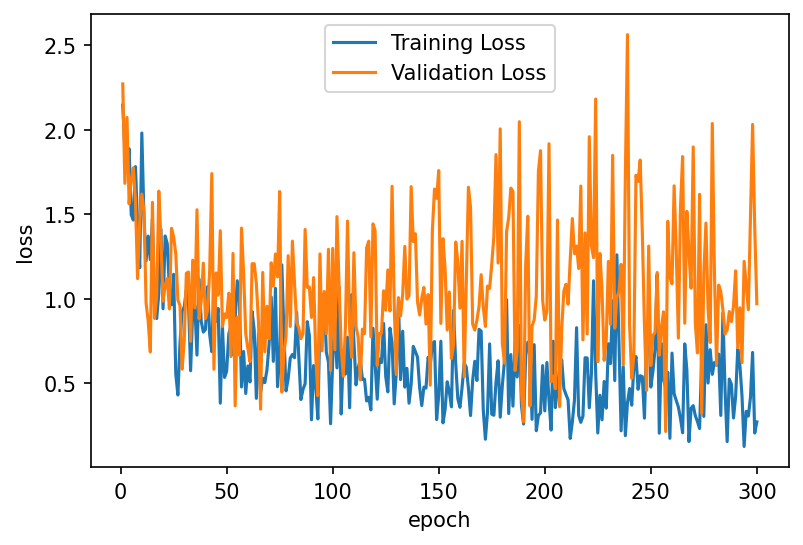

In [20]:
t_range = torch.arange(1, 301)

fig = plt.figure(dpi=150)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(t_range, torch.FloatTensor(test_1b[1]).cpu(), label='Training Loss')
plt.plot(t_range, torch.FloatTensor(test_1b[3]).cpu(), label='Validation Loss')
plt.legend()
plt.show()

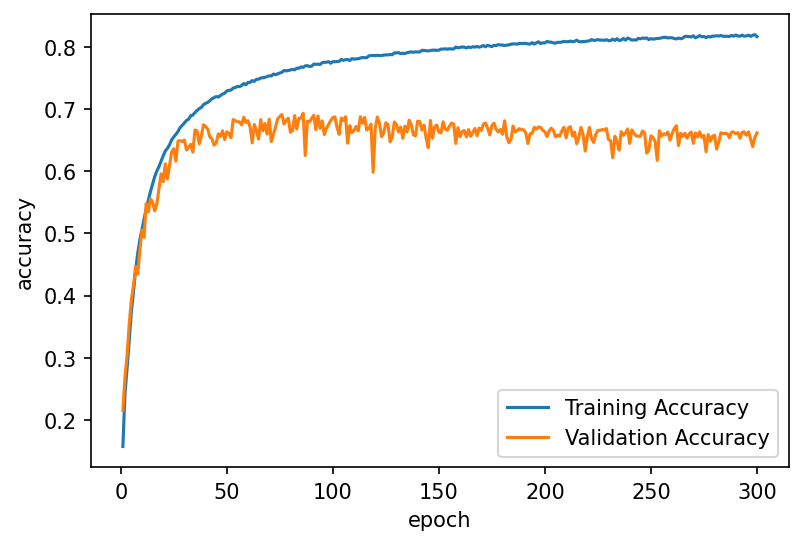

In [21]:
t_range = torch.arange(1, 301)

fig = plt.figure(dpi=150)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(t_range, torch.FloatTensor(test_1b[0]).cpu(), label='Training Accuracy')
plt.plot(t_range, torch.FloatTensor(test_1b[2]).cpu(), label='Validation Accuracy')
plt.legend()
plt.show()